# Capital One Job Posting Analysis

Captial One has a reputation as a great place to work, the headquarters is three miles from my house, and is known for its widespread use of data analytcis throughout hte organization. There are always a lot of jobs posted, but without knowing the internal structure and divisions of the company, they are hard to assess given the titles alone.

## Web Scraping
Scraping job descrptions - First I read the terms and conditions of the website and also explored the robot.txt file. After confirming scraping the Capital One Career page was permissible, I searched for open jobs based on location (McLean, VA) and category in which I selected both “Analytics” and “Data Science.” This resulted in 108 jobs. I pulled the URLs into a CSV file.

I used Scrapy and a basic spider script to scrape the data. From each job posting, the program pulled the following items: url [job posting url], title [job title] , job_id  [job ID from posting], updated [date the post was updated], and text [job description text]. 

## Text Analysis
In this notebook, I cluster the job descriptions using different vectorization appraches. I use PCA and t-SNE for dimensionality reduction and visualization of the clusters. I use hierarchical clustering for the terms in the corpus.


In [390]:
import re,string
import json
import nltk
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from pprint import pprint
import pandas as pd
import os

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as pyplt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import multiprocessing

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
import sklearn.linear_model 

from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# set working file
os.chdir('/Users/rachelmartonik/MSDS_453_NLP')

In [391]:
#### Read in data ####
# Read in Job Data
import json
import pandas as pd
json_file='/Users/rachelmartonik/MSDS_453_NLP/JobPostSpider/items.jl'
jobs = pd.read_json(json_file, lines=True)

jobs.head()

url  \
0  https://www.capitalonecareers.com/job/mclean/d...   
1  https://www.capitalonecareers.com/job/mclean/d...   
2  https://www.capitalonecareers.com/job/mclean/d...   
3  https://www.capitalonecareers.com/job/chicago/...   
4  https://www.capitalonecareers.com/job/mclean/d...   

                                        title             job_id  \
0                              Data Scientist  [Job ID,  R90676]   
1                    Data Scientist, Card DS+  [Job ID,  R90624]   
2         Data Scientist, Small Business Card  [Job ID,  R90625]   
3  Senior Associate, Data Scientist, Card DS+  [Job ID,  R90483]   
4    Data Scientist, Digital Machine Learning  [Job ID,  R90548]   

                       updated  \
0  [Updated date,  01/17/2020]   
1  [Updated date,  01/17/2020]   
2  [Updated date,  01/17/2020]   
3  [Updated date,  01/16/2020]   
4  [Updated date,  01/16/2020]   

                                                text  
0  Recruiting: VA - McLean, United States of Amer...  
1  McLean 2 (19052), United States of America, Mc...  
2  McLean 2 (19052), United States of America, Mc...  
3  77 West Wacker Dr (35012), United States of Am...  
4  McLean 2 (19052), United States of America, Mc...

In [392]:
print(jobs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      107 non-null    object
 1   title    107 non-null    object
 2   job_id   107 non-null    object
 3   updated  107 non-null    object
 4   text     107 non-null    object
dtypes: object(5)
memory usage: 4.3+ KB
None


In [393]:
# Get rid of job_id and updated lists
jobs = jobs.applymap(lambda x: x[1] if isinstance(x, list) else x)
#jobs

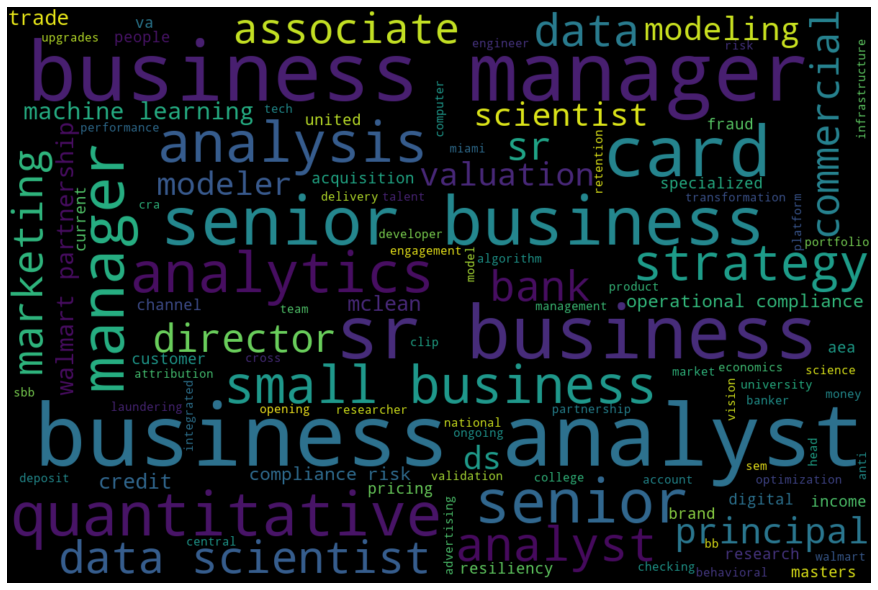

In [394]:
#### Word cloud of job titles ####
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
comment_words = ' '
stopwords = set(STOPWORDS) 
 
# iterate through the csv file 
for val in jobs.title: 
     
   # typecaste each val to string 
   val = str(val) 
 
   # split the value 
   tokens = val.split() 
     
   # Converts each token into lowercase 
   for i in range(len(tokens)): 
       tokens[i] = tokens[i].lower() 
         
   for words in tokens: 
       comment_words = comment_words + words + ' '
 
 
wordcloud = WordCloud(width = 1200, height = 800, 
               background_color ='black', 
               stopwords = stopwords, 
               min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('job title word cloud.png')
plt.show() 


In [395]:
data = jobs
#print to show the first and last 10 documents
print('\nGlimpse of beginning of corpus data frame:\n')
print(data.head(10))


Glimpse of beginning of corpus data frame:

                                                 url  \
0  https://www.capitalonecareers.com/job/mclean/d...   
1  https://www.capitalonecareers.com/job/mclean/d...   
2  https://www.capitalonecareers.com/job/mclean/d...   
3  https://www.capitalonecareers.com/job/chicago/...   
4  https://www.capitalonecareers.com/job/mclean/d...   
5  https://www.capitalonecareers.com/job/richmond...   
6  https://www.capitalonecareers.com/job/mclean/p...   
7  https://www.capitalonecareers.com/job/mclean/s...   
8  https://www.capitalonecareers.com/job/mclean/s...   
9  https://www.capitalonecareers.com/job/mclean/s...   

                                               title   job_id      updated  \
0                                     Data Scientist   R90676   01/17/2020   
1                           Data Scientist, Card DS+   R90624   01/17/2020   
2                Data Scientist, Small Business Card   R90625   01/17/2020   
3         Senior Associate

In [396]:
#print(data['text'][0])

In [397]:
#data['text']

In [398]:
#create empty list to store text documents
text_body=[]

#for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['text'].iloc[i]
    text_body.append(temp_text)

In [399]:
#text_body[0]

In [400]:
#### Remove generic Cap 1 description and Equal Opportunity Employer
shortened_text1=[]
for i in text_body:
    text= i.rsplit('Capital One will consider',)[0]
    shortened_text1.append(text)

#print(shortened_text1)

In [401]:
# Cut off the first Cap 1 paragraph
shortened_text=[]
for i in shortened_text1:
    text= i.rsplit('financial lives.', )[-1]
    shortened_text.append(text)
    
#print(shortened_text[0])

# Cleaning the documents

In [402]:
# Settings for vectorization
STEMMING = False  # judgment call, parsed documents more readable if False
MAX_NGRAM_LENGTH = 2  # Experiment with n-gram length
VECTOR_LENGTH = 20000  # set vector length for TF-IDF and Doc2Vec

In [403]:
# This clean doc function is only used for the analyst judgement vectors (Count and Hash)
# Use more generic for TFIDF and Doc2Vec

from nltk.corpus import stopwords

# Function to clean documents
def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # Change numbers to words to incorporate years experience
    re_word = re.compile(r'1')
    tokens = [re_word.sub('one', w) for w in tokens]
    re_word = re.compile(r'2')
    tokens = [re_word.sub('two', w) for w in tokens]
    re_word = re.compile(r'3')
    tokens = [re_word.sub('three', w) for w in tokens]
    re_word = re.compile(r'4')
    tokens = [re_word.sub('four', w) for w in tokens]
    re_word = re.compile(r'5')
    tokens = [re_word.sub('five', w) for w in tokens]
    re_word = re.compile(r'6')
    tokens = [re_word.sub('six', w) for w in tokens]
    re_word = re.compile(r'7')
    tokens = [re_word.sub('seven', w) for w in tokens]
    re_word = re.compile(r'8')
    tokens = [re_word.sub('eight', w) for w in tokens]
    re_word = re.compile(r'9')
    tokens = [re_word.sub('nine', w) for w in tokens]
    re_word = re.compile(r'10')
    tokens = [re_word.sub('ten', w) for w in tokens]
    re_word = re.compile(r'1+')
    tokens = [re_word.sub('one plus', w) for w in tokens]
    re_word = re.compile(r'2+')
    tokens = [re_word.sub('two plus', w) for w in tokens]
    re_word = re.compile(r'3+')
    tokens = [re_word.sub('three plus', w) for w in tokens]
    re_word = re.compile(r'4+')
    tokens = [re_word.sub('four plus', w) for w in tokens]
    re_word = re.compile(r'5+')
    tokens = [re_word.sub('five plus', w) for w in tokens]
    re_word = re.compile(r'6+')
    tokens = [re_word.sub('six plus', w) for w in tokens]
    re_word = re.compile(r'7+')
    tokens = [re_word.sub('seven plus', w) for w in tokens]
    re_word = re.compile(r'8+')
    tokens = [re_word.sub('eight plus', w) for w in tokens]
    re_word = re.compile(r'9+')
    tokens = [re_word.sub('nine plus', w) for w in tokens]
    re_word = re.compile(r'10+')
    tokens = [re_word.sub('ten plus', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # # filter out short tokens
    #tokens = [word for word in tokens if len(word) > 1]
    # #lowercase all words
    tokens = [word.lower() for word in tokens]
    # Manually clean equivalent classes
    re_word = re.compile(r'opensource')
    tokens = [re_word.sub('open source', w) for w in tokens]
    re_word = re.compile(r'beyondtechnical')
    tokens = [re_word.sub('beyond technical', w) for w in tokens]
    re_word = re.compile(r'sciencebasic')
    tokens = [re_word.sub('science basic', w) for w in tokens]
    re_word = re.compile(r'analysisat')
    tokens = [re_word.sub('analysis at', w) for w in tokens]
    re_word = re.compile(r'databasespreferred')
    tokens = [re_word.sub('databases preferred', w) for w in tokens]
    re_word = re.compile(r'descriptionsmall')
    tokens = [re_word.sub('description small', w) for w in tokens]
    re_word = re.compile(r'businessgrade')
    tokens = [re_word.sub('business grade', w) for w in tokens]
    re_word = re.compile(r'customerfirst')
    tokens = [re_word.sub('customer first', w) for w in tokens]
    re_word = re.compile(r'descriptionin')
    tokens = [re_word.sub('description in', w) for w in tokens]
    re_word = re.compile(r'willpartner')
    tokens = [re_word.sub('will partner', w) for w in tokens]
    re_word = re.compile(r'loveleverage')
    tokens = [re_word.sub('love leverage', w) for w in tokens]
    re_word = re.compile(r'stateoftheart')
    tokens = [re_word.sub('state of the art', w) for w in tokens]
    re_word = re.compile(r'stepchange')
    tokens = [re_word.sub('step change', w) for w in tokens]
    re_word = re.compile(r'lead')
    tokens = [re_word.sub('drive', w) for w in tokens]
    # # filter out stop words
    stop_words = list(stopwords.words('english'))
    stop_words.append('capital')
    stop_words.append('one')
    stop_words.append('one')
    stop_words.append('years')
    stop_words.append('experience')
    stop_words.append('years experience')
    stop_words.append('captial one')
    stop_words.append('mclean')
    stop_words.append('heshe')
                      
    tokens = [w for w in tokens if not w in stop_words]         
    # # word stemming Commented
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens

In [404]:
# Create empty list to store text documents labels (job titles)
labels=[]

#Append job titles to label list
for i in range(0,len(data)):
    temp_text=data['title'].iloc[i]
    labels.append(temp_text)

# # Append job titles to label list
# for i in range(0,len(data)):
#     temp_text=data['job_id'].iloc[i]
#     labels.append(temp_text)   
        
# Create empty list to store processed documents
processed_text=[]

# Process documents
for i in shortened_text:
    text=clean_doc(i)
    processed_text.append(text)
    
#processed_text

In [405]:
# Combine for final processed text list
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)
    
type(final_processed_text)
#the following is an example of what the processed text looks like.  
print('\nExample of what one parsed document looks like:\n')
print(final_processed_text[4])


Example of what one parsed document looks like:

team descriptiondigital ml data science machine learning team inside digital products organization deliver realtime personalized intelligent customer experiences suite awardwinning digital products including website mobile app emails chatbot beyond partner closely product engineering teams build data modeling platforms crucial deep understanding customers enables applications delight adapting needsas part digital ml willexplore billions clickstream events discover patterns customer behavior use patterns model key customer outcomesbuild leverage enterprisewide taxonomy customer data optimize digital marketing initiativesdevelop realtime models use vast amounts customer data anticipate needs deliver right message right timedevelop models ensure important customer data accurate fighting fraud bad behavior enabling seamless digital experiences across productsrole description in digital ml work phases data science life cycle includingbuild m

# Classification
For this assignment I need some way of comparing the three type of vectorizations (manual analyst judgement, TF-IDF, and NN word embeddings). The Capital One job descriptions do not have any natural classifications and this is one of the issues with the job postings--it is hard to decipher what department or at what level many of the jobs are.

I reviewed each job description and created the following three variables that could be used for classificaiton:

1) __level__ - "junior", "mid", and "senior" based on my assessment of the job duties and experiences required (both basic and preferred qualifications.) Admittedly, this is a subjective rating. However, I generally followed the following guidelines:

    junior= bach degree, 1-2 years experience

    Mid= masters degree (or bach with more experience), 2-3/4 years depending on description

    Senior= pHD, 3+ years

2) __interested__ - whether or not I am intersted in the job (mainly based off of actual job duties and content area, not level or if I was/was not qualified)

3) __department__ - if a specific department (i.e. Small Business Bank) was listed. Otherwise coded as "generic"


In [406]:
# # Classification - The job descriptions are not labeled. I need to label them. Export file to add classifications.
# jobs.to_csv('/Users/rachelmartonik/MSDS_453_NLP/jobs2.csv', index=True)

In [407]:
# import pandas as pd
# jobs2 = pd.read_excel('jobs_wTarget.xlsm')
# jobs2.head()

In [408]:
# #Combine imported file with targets to existing jobs dataframe
# jobs_targets = pd.concat([jobs2,jobs], axis = 1)
# jobs_targets.info()

In [409]:
# jobs_targets.head()

In [410]:
# # Add numeric target for classification
# from sklearn.preprocessing import LabelEncoder
# jobs_targets["level_target"] = LabelEncoder().fit_transform(jobs_targets.level)
# jobs_targets["interested_target"] = LabelEncoder().fit_transform(jobs_targets.interested)
# jobs_targets["department_target"] = LabelEncoder().fit_transform(jobs_targets.department)
# print(jobs_targets["level_target"].value_counts())
# print(jobs_targets["interested_target"].value_counts())
# #print(jobs_targets["department_target"].value_counts())

# Clustering
Below I cluster the job descriptions using 4 different vectorizations, all using 500 words:

1) Count Vectorization

2) Hash Vectorization

3) TF-IDF Vectorization

4) Doc2Vec Vectorization

In [411]:
RANDOM = 36 # To be reproducible
# Create Job Descriptopn labels to use later
job_labels=[]

#Append job titles to label list
for i in range(0,len(data)):
    temp_text=data['title'].iloc[i]
    job_labels.append(temp_text)

In [412]:
#PCA fucntions of word vectors - with and without labels

# PCA Scatterplot
def princomp_scatter_labels(vector):
    pca = PCA(n_components=2, random_state=RANDOM)
    result = pca.fit_transform(vector)
    plt.figure(figsize = (20, 16))
    plt.scatter(result[:, 0], result[:, 1])
    words = list(data['title'])
    for i, word in enumerate(words):
      plt.annotate(word, size = 18, xy=(result[i, 0], result[i, 1]))
    plt.show()
    
def princomp_scatter(vector):
    pca = PCA(n_components=2, random_state=RANDOM)
    result = pca.fit_transform(vector)
    plt.figure(figsize = (10, 7))
    plt.scatter(result[:, 0], result[:, 1])
    plt.show()

In [413]:
######### MATRIX 1 - Count Vectorization using max vocab words #########
MAX_NGRAM_LENGTH = 2
VECTOR_LENGTH=500
count_vectorizer = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
count_vectors = count_vectorizer.fit_transform(final_processed_text)
count_vect_df = pd.DataFrame(count_vectors.todense(), columns=count_vectorizer.get_feature_names(), index=job_labels)
count_vect_df.head()

ability  ability drive  able  \
Data Scientist                                    0              0     0   
Data Scientist, Card DS+                          0              0     0   
Data Scientist, Small Business Card               0              0     0   
Senior Associate, Data Scientist, Card DS+        0              0     0   
Data Scientist, Digital Machine Learning          0              0     0   

                                            able bring  able drive  achieve  \
Data Scientist                                       0           0        0   
Data Scientist, Card DS+                             0           0        0   
Data Scientist, Small Business Card                  0           0        0   
Senior Associate, Data Scientist, Card DS+           0           0        0   
Data Scientist, Digital Machine Learning             0           0        0   

                                            achieve goals  achieving  \
Data Scientist                                          0          0   
Data Scientist, Card DS+                                0          0   
Data Scientist, Small Business Card                     0          0   
Senior Associate, Data Scientist, Card DS+              0          1   
Data Scientist, Digital Machine Learning                0          0   

                                            achieving short  across  ...  \
Data Scientist                                            0       0  ...   
Data Scientist, Card DS+                                  0       1  ...   
Data Scientist, Small Business Card                       0       1  ...   
Senior Associate, Data Scientist, Card DS+                0       1  ...   
Data Scientist, Digital Machine Learning                  0       2  ...   

                                            well breakthrough  work  \
Data Scientist                                              0     2   
Data Scientist, Card DS+                                    0     2   
Data Scientist, Small Business Card                         0     2   
Senior Associate, Data Scientist, Card DS+                  0     2   
Data Scientist, Digital Machine Learning                    0     1   

                                            work closely  worldclass  \
Data Scientist                                         0           0   
Data Scientist, Card DS+                               0           0   
Data Scientist, Small Business Card                    0           0   
Senior Associate, Data Scientist, Card DS+             0           0   
Data Scientist, Digital Machine Learning               0           0   

                                            worldclass professionals  written  \
Data Scientist                                                     0        0   
Data Scientist, Card DS+                                           0        0   
Data Scientist, Small Business Card                                0        0   
Senior Associate, Data Scientist, Card DS+                         0        0   
Data Scientist, Digital Machine Learning                           0        0   

                                            written oral  year  yet  \
Data Scientist                                         0     3    0   
Data Scientist, Card DS+                               0     3    0   
Data Scientist, Small Business Card                    0     5    0   
Senior Associate, Data Scientist, Card DS+             0     3    0   
Data Scientist, Digital Machine Learning               0     4    0   

                                            yet responsible  
Data Scientist                                            0  
Data Scientist, Card DS+                                  0  
Data Scientist, Small Business Card                       0  
Senior Associate, Data Scientist, Card DS+                0  
Data Scientist, Digital Machine Learning                  0  

[5 rows x 500 columns]

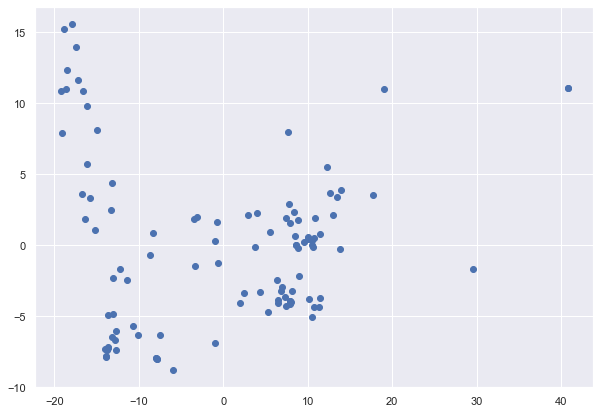

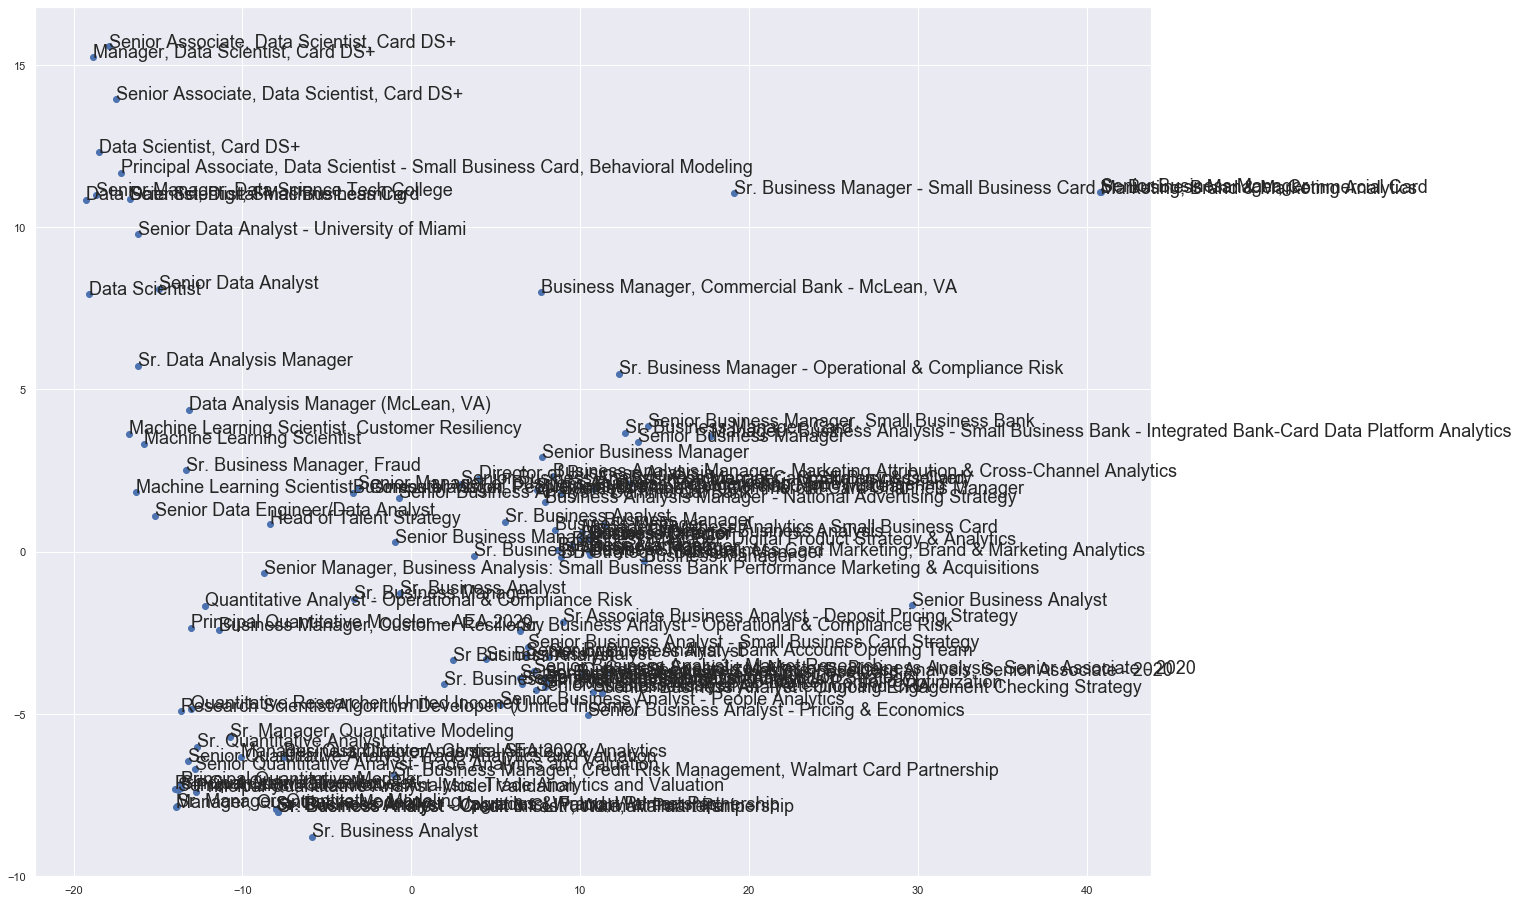

In [414]:
#PCA of count vectorizer
princomp_scatter(count_vect_df) 
princomp_scatter_labels(count_vect_df)

In [415]:
######### MATRIX 1a - Hashing Vectorization #########
MAX_NGRAM_LENGTH = 1
#VECTOR_LENGTH=len(vocab)
VECTOR_LENGTH=500

hashing_vectorizer = HashingVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), n_features = VECTOR_LENGTH)
hashing_vectors = hashing_vectorizer.fit_transform(final_processed_text)

hash_vect_df = pd.DataFrame(hashing_vectors.todense(), columns=count_vectorizer.get_feature_names(), index=labels)
#hash_vect_df.head()


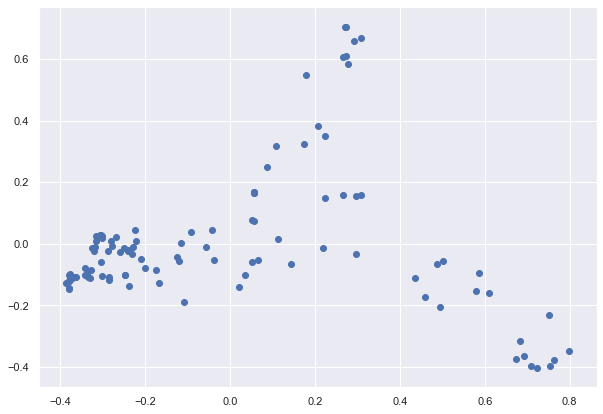

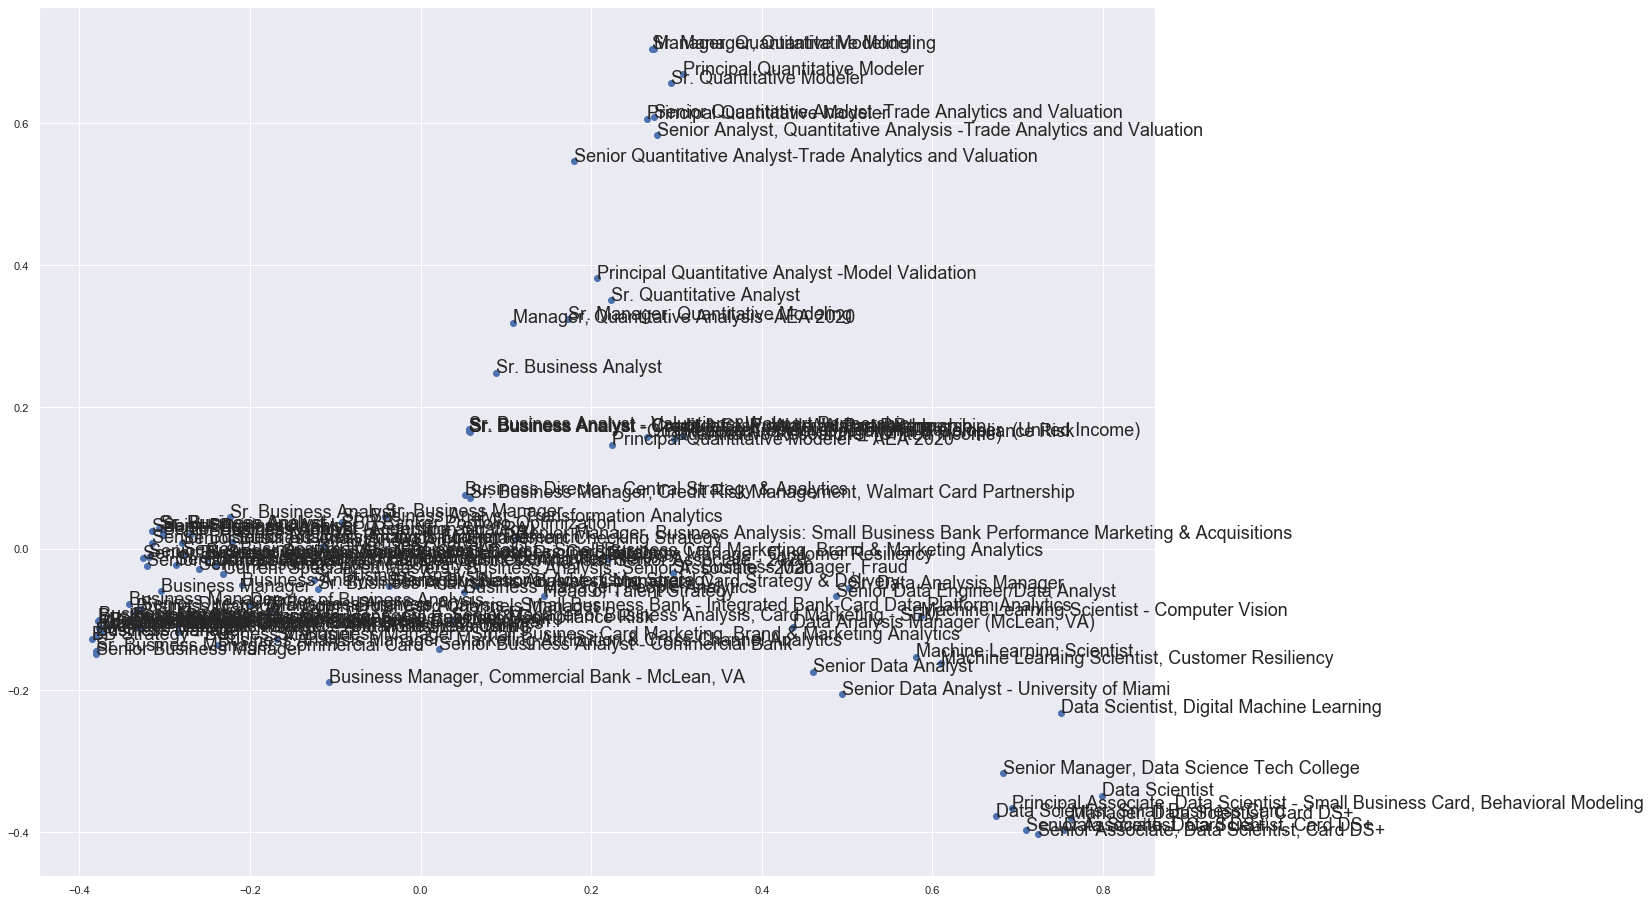

In [416]:
#PCA of count vectorizer
princomp_scatter(hash_vect_df) 
princomp_scatter_labels(hash_vect_df)

In [417]:
####### MATRIX 2 - TF-IDF Vectorization using max vocab words #########

# Basic cleans for TF-IDF (different than Count vectorization)
from nltk.corpus import stopwords

# Function to clean documents
def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    # # filter out short tokens
    #tokens = [word for word in tokens if len(word) > 1]
    # #lowercase all words
    tokens = [word.lower() for word in tokens]  
    stop_words = list(stopwords.words('english'))
    stop_words.append('capital')
    stop_words.append('one')
    stop_words.append('years')
    stop_words.append('experience')
    stop_words.append('years experience')
    stop_words.append('captial one')
    stop_words.append('mclean')
    tokens = [w for w in tokens if not w in stop_words]         
    # # word stemming Commented
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens

In [418]:
# Prepare Entire Data Set for TF-IDF
data = data
text_body=[]
for i in range(0,len(data)):
    temp_text=data['text'].iloc[i]
    text_body.append(temp_text)
    
processed_text=[]
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)
    
final_processed_text=[]
for i in processed_text:
    temp_DSI=" ".join(str(item) for item in i )
    final_processed_text.append(temp_DSI)


In [419]:
### Sklearn TFIDF 
VECTOR_LENGTH = 500
MAX_NGRAM_LENGTH = 1

# Note the ngram_range will allow you to include multiple-word tokens within the TFIDF matrix
Tfidf=TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
TFIDF_matrix=Tfidf.fit_transform(final_processed_text)     

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns = Tfidf.get_feature_names(), index=labels)

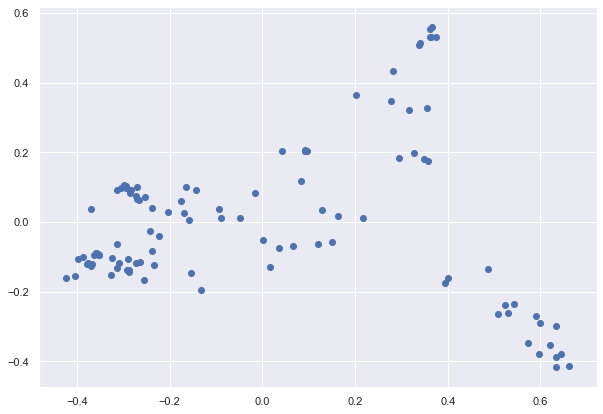

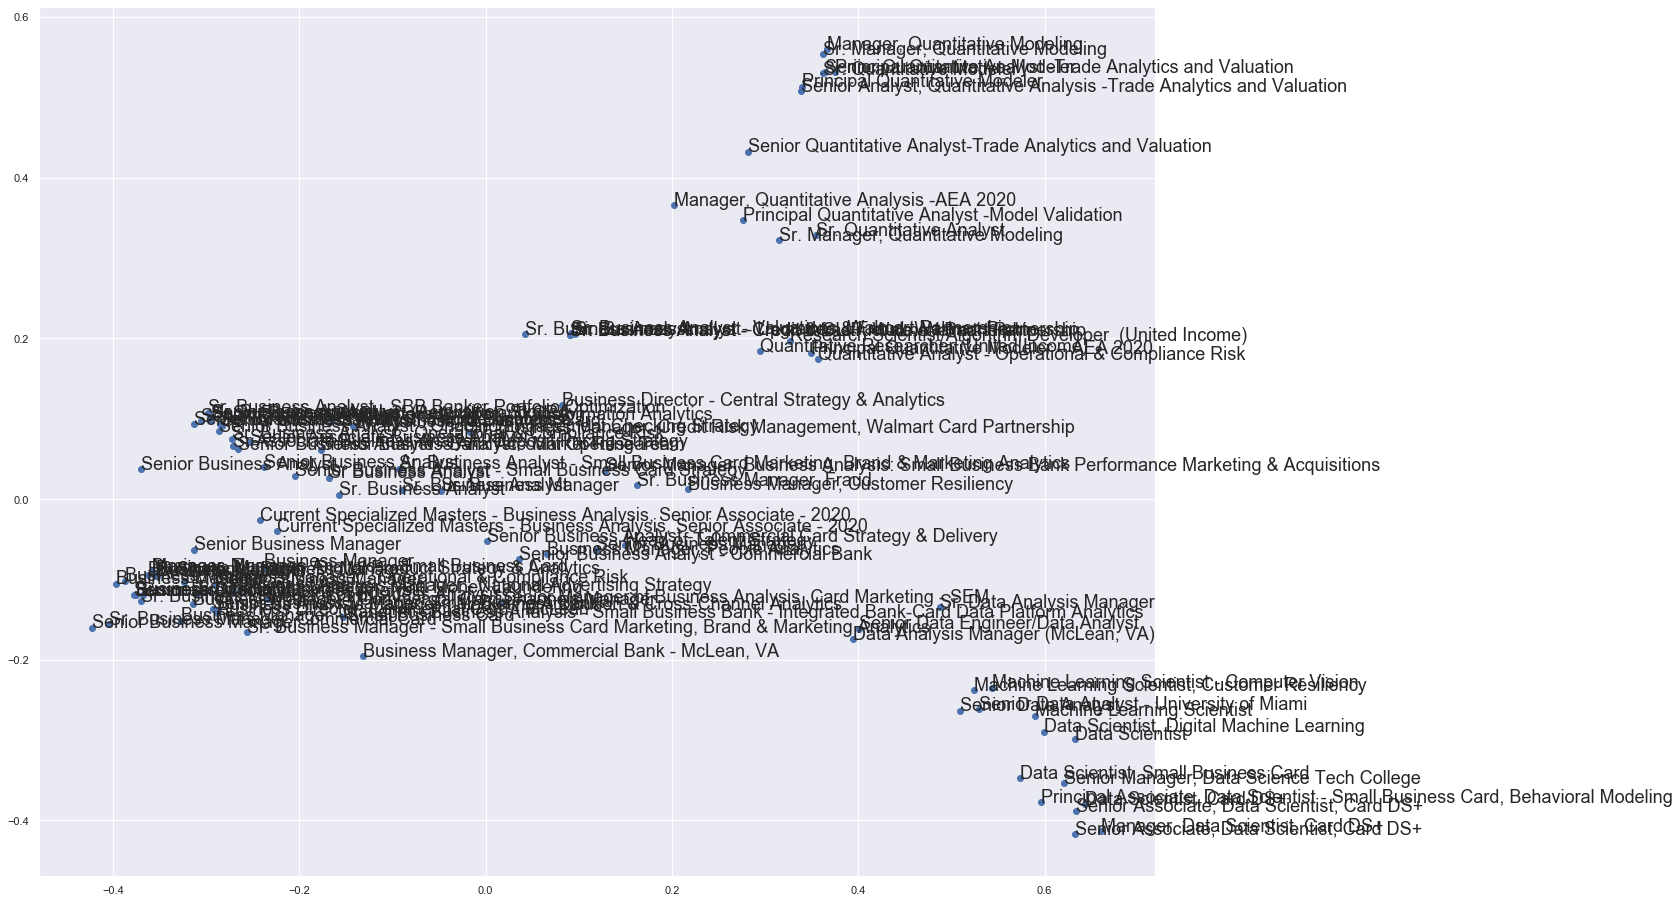

In [420]:
#PCA of count vectorizer
princomp_scatter(matrix) 
princomp_scatter_labels(matrix)

In [421]:
# Doc2Vec
# Basic cleans for Doc2Vec
from nltk.corpus import stopwords

# Function to clean documents
def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens]
    stop_words = list(stopwords.words('english'))
    stop_words = list(stopwords.words('english'))
    stop_words.append('capital')
    stop_words.append('one')
    stop_words.append('years')
    stop_words.append('experience')
    stop_words.append('years experience')
    stop_words.append('captial one')
    stop_words.append('mclean')
    tokens = [w for w in tokens if not w in stop_words]         
    # # word stemming Commented
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens

text_body=[]
for i in range(0,len(data)):
    temp_text=data['text'].iloc[i]
    text_body.append(temp_text)
    
processed_text=[]
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)
    
final_processed_text=[]
for i in processed_text:
    temp_DSI=" ".join(str(item) for item in i )
    final_processed_text.append(temp_DSI)

In [422]:
print("\nWorking on Doc2Vec vectorization")
VECTOR_LENGTH = 500
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(processed_text)]
model = Doc2Vec(documents, vector_size = VECTOR_LENGTH, window = 2, min_count = 1, workers = 4)


Working on Doc2Vec vectorization


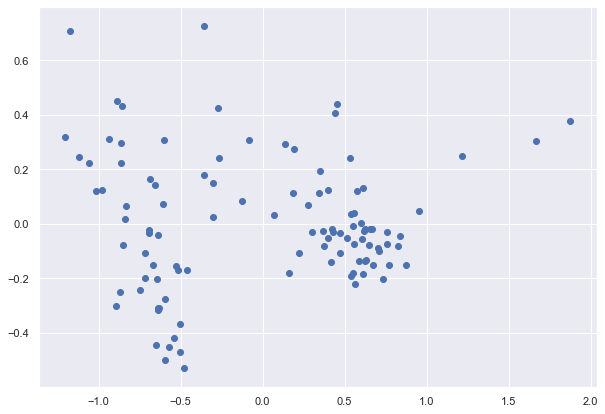

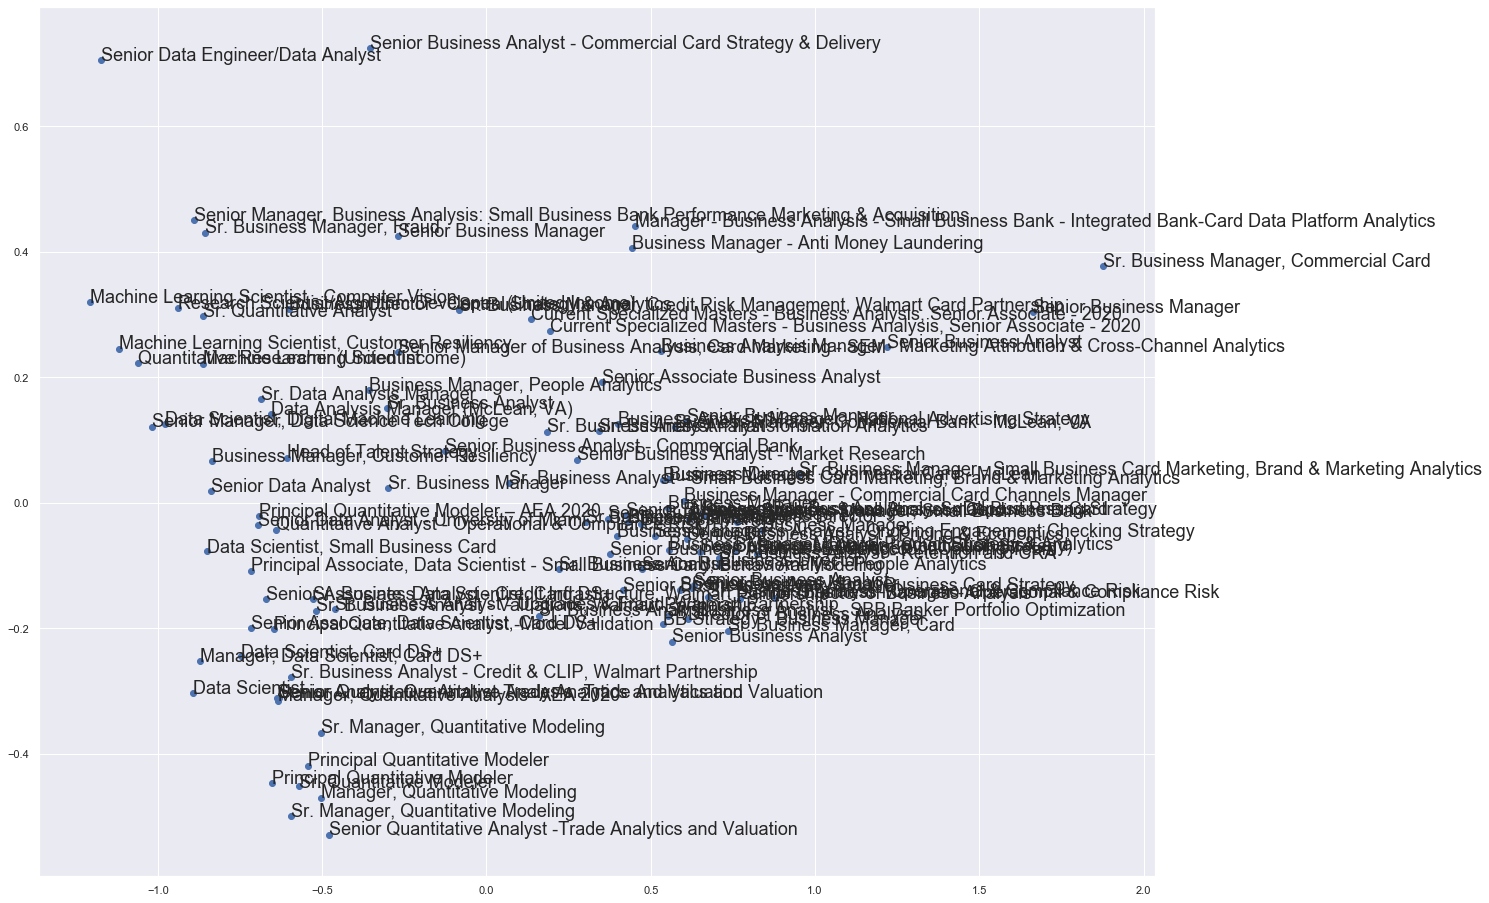

In [423]:
doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': job_labels}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)
doc2vec_df=doc2vec_df.set_index('title')

princomp_scatter(doc2vec_df) 
princomp_scatter_labels(doc2vec_df)

# Clustering

It can be noted that k-means (and minibatch k-means) are very sensitive to feature scaling and that in this case the IDF weighting helps improve the quality of the clustering by quite a lot as measured against the “ground truth” provided by the class label assignments of the 20 newsgroups dataset.

In [424]:
# Clustering
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
RANDOM = 36

# Skree plot function
def elbow_plot(df, num_clusters):
    wcss = []
    for i in range(1, num_clusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=RANDOM)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
    features = range(1,20)

    plt.plot(features, wcss, '-o', color='black')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

# Silhouette analysis can be used to determine the degree of separation between clusters.
from sklearn.metrics import silhouette_samples, silhouette_score

def silhouette_samples_viz(df, clust_range):
    for i, k in enumerate(clust_range):
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)
    
        # Run the Kmeans algorithm
        km = KMeans(n_clusters=k)
        labels = km.fit_predict(df)
        centroids = km.cluster_centers_

        # Get silhouette samples
        silhouette_vals = silhouette_samples(df, labels)

        # Silhouette plot
        y_ticks = []
        y_lower, y_upper = 0, 0
        for i, cluster in enumerate(np.unique(labels)):
            cluster_silhouette_vals = silhouette_vals[labels == cluster]
            cluster_silhouette_vals.sort()
            y_upper += len(cluster_silhouette_vals)
            ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
            ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
            y_lower += len(cluster_silhouette_vals)

        # Get the average silhouette score and plot it
        avg_score = np.mean(silhouette_vals)
        ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
        ax1.set_yticks([])
        ax1.set_xlim([-0.1, 1])
        ax1.set_xlabel('Silhouette coefficient values')
        ax1.set_ylabel('Cluster labels')
        ax1.set_title('Silhouette plot for the various clusters', y=1.02);
        
# Function to plot cluster results on PCA map by color
def princomp_scatter_color(vector):
    pca = PCA(n_components=2, random_state=RANDOM)
    result = pca.fit_transform(vector)
    plt.figure(figsize = (10, 7))
    plt.scatter(result[:, 0], result[:, 1], c=kmeans.labels_.astype(float))
    plt.show()
    
# Function to get top 15 words in each cluster - counts
def word_freq_df(dataframe):
    freq = dataframe.sum(axis=0)
    freq = freq.to_frame()
    freq = freq[1:]
    freq = freq.rename(columns={0: "frequency"})
    print(freq.sort_values('frequency', ascending=False).head(15))
    
# Function to get top 15 words in each cluster - mean
def word_mean_df(dataframe):
    freq = dataframe.mean(axis=0)
    freq = freq.to_frame()
    freq = freq[1:]
    freq = freq.rename(columns={0: "mean"})
    print(freq.sort_values('mean', ascending=False).head(15))

## Matrix 1 - Count Vectorizer

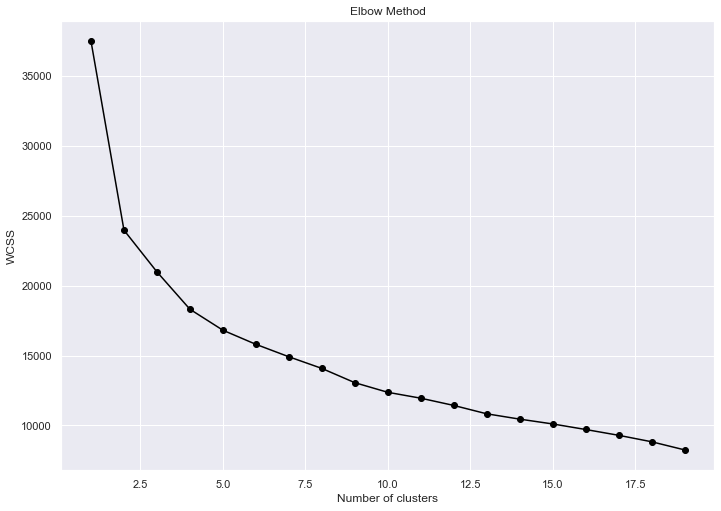

In [425]:
##### MATRIX 1 - Count Vectorizer  #####
elbow_plot(count_vect_df, 20)

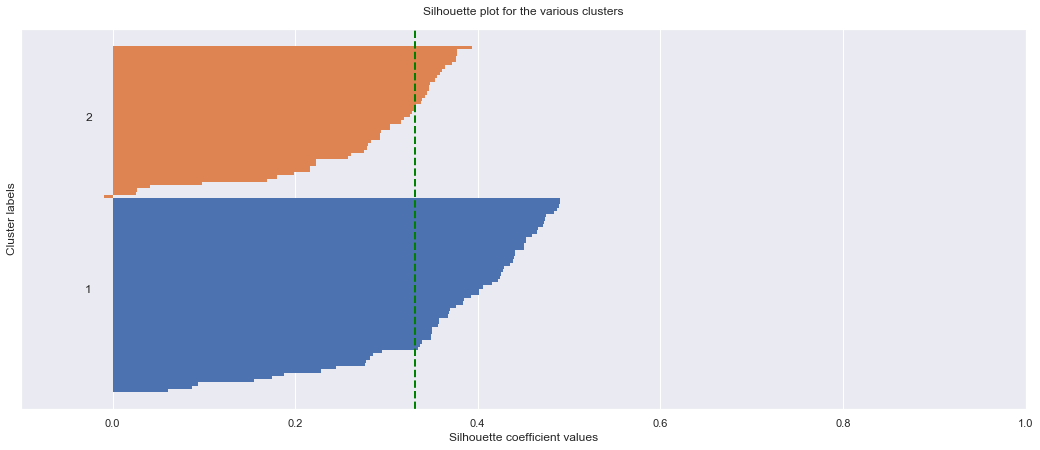

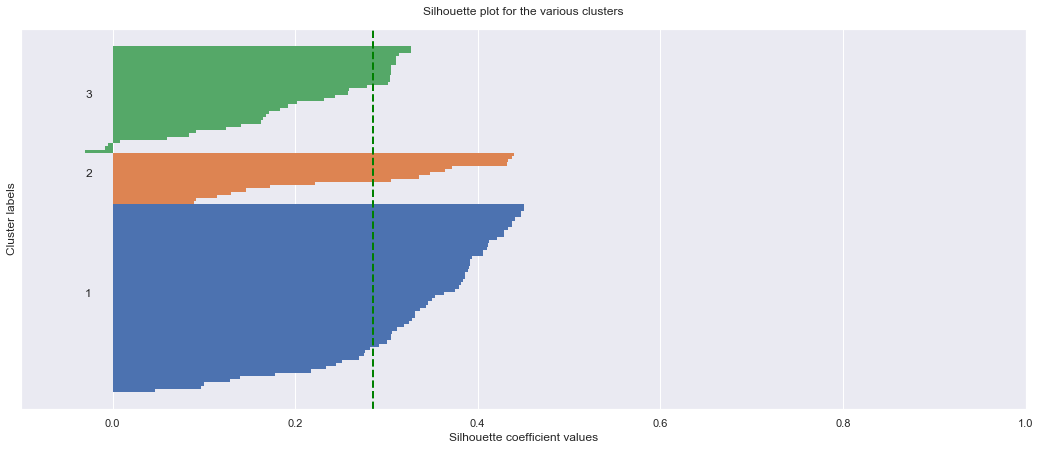

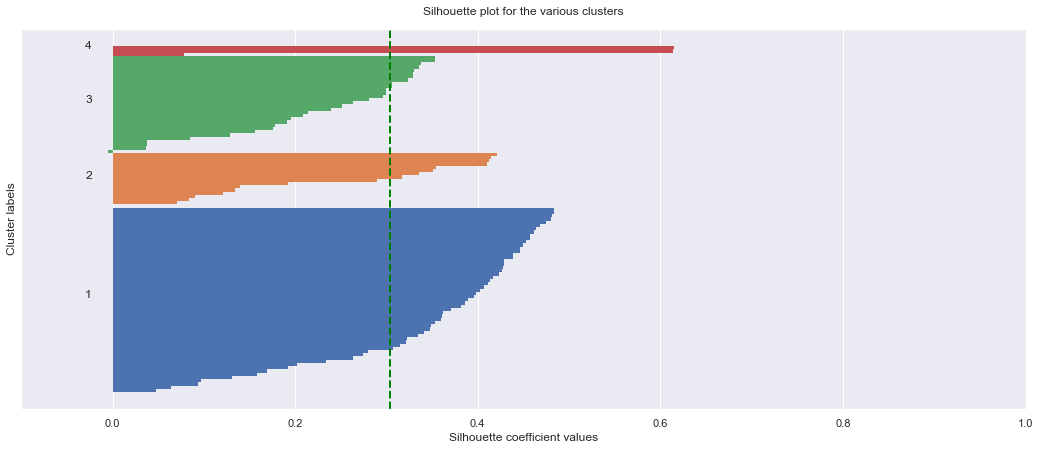

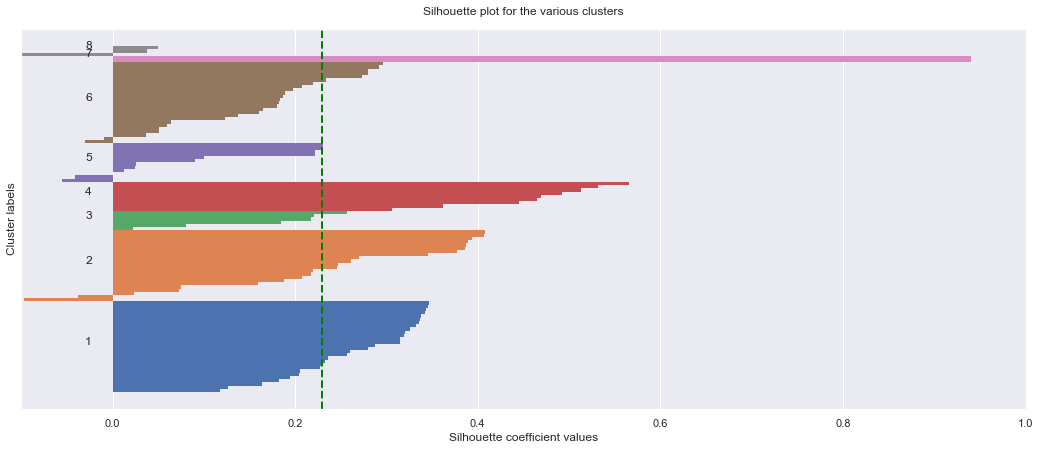

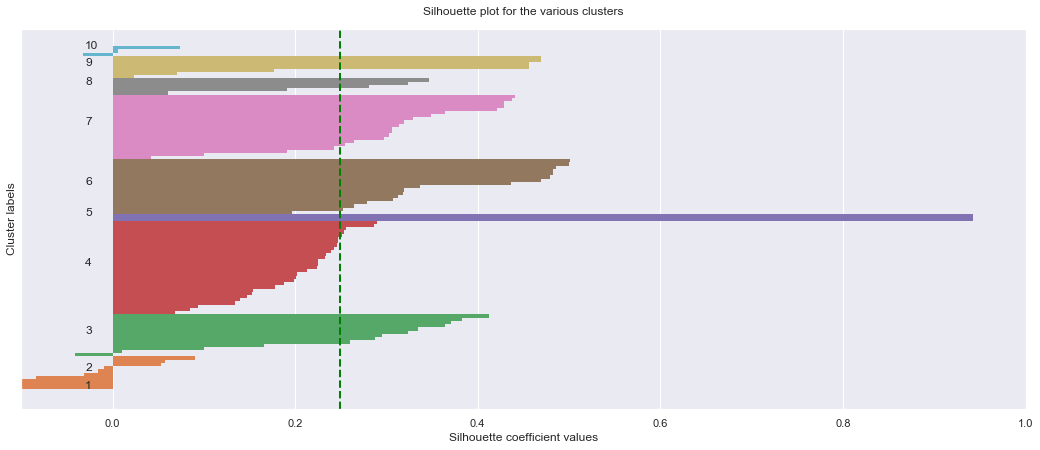

In [426]:
# Silhoutte plot
df = count_vect_df
clust_range = [2,3,4,8,10]
silhouette_samples_viz(df, clust_range)

# 2,3 and 4 clusters looks the best on elbow plot and silhouette plot
# One outling cluster no matter what I do

WCSS: 18314.379802052783


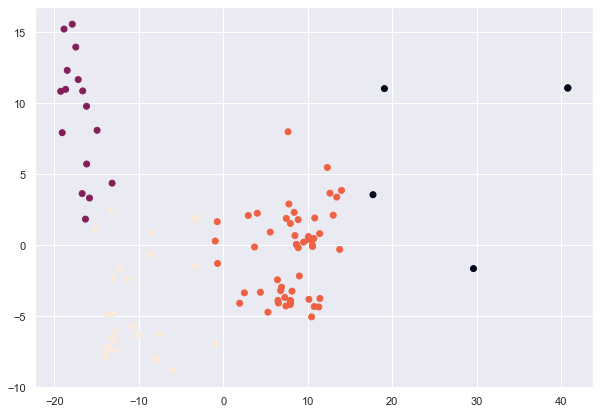

In [427]:
# Cluster Matrix 1 - Count Vectorizer
n_clusters=4
kmeans = KMeans(n_clusters, random_state=RANDOM).fit(count_vect_df)
print('WCSS:', kmeans.inertia_)
labels = kmeans.labels_

princomp_scatter_color(count_vect_df)

In [428]:
# Create dataframe for exploration of clusters
clusters1 = count_vect_df.copy()
clusters1['clusters']= labels #Glue back to original data
clusters1.reset_index(inplace=True)
clusters1 = clusters1.rename(columns={"index": "titles"}) # need to get job titles off of index


# Multidemsional Scaling with t-SNE

Using matrices for Approaches 1, 2, and 3, perform multidimensional scaling with documents as objects. Visualize the multidimensional scaling solutions in two-space, labeling points with document names. Identify clusters from the K-means clustering with colored points, providing a legend on the visualization. Use t-distributed stochastic neighbor embedding (t-SNE) for the multidimensional scaling. If there is a large number of documents, plot a sample of the documents. Describe the results. 

__MDS__ - reduces dimensionality while trying to presrve the distances between the instances.

__t-SNE__ - reduces dimension while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization to view clusters.

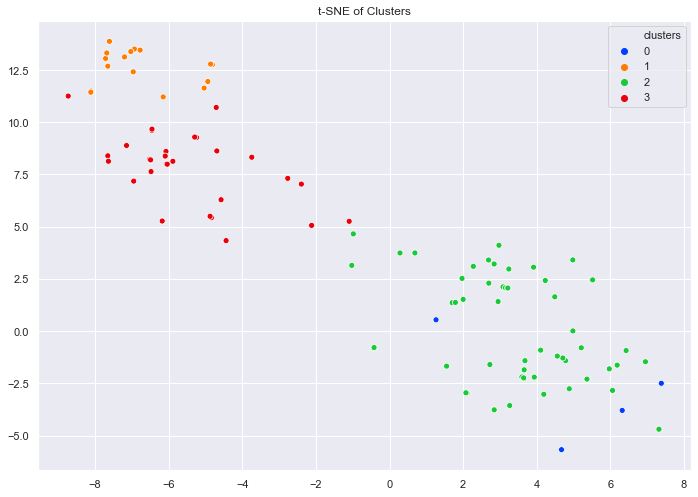

In [429]:
# T-SNE vizualization with clusterung
sns.set(rc={'figure.figsize':(11.7,8.27)})
tsne = TSNE(random_state=RANDOM, learning_rate=150, perplexity=25)
X_embedded = tsne.fit_transform(count_vect_df)
palette = sns.color_palette("bright", 4)
y = clusters1['clusters']
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette).set_title('t-SNE of Clusters')
plt.savefig('tSNE_matrix1.png')

In [430]:
# It is highly recommended to use another dimensionality reduction method 
# (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount 
# (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation 
# of pairwise distances between samples. 

# Lets try to reduce the data set

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=36)
result = svd.fit_transform(count_vect_df)
result

array([[ 4.91986488e+00,  1.04150115e+01,  7.91730559e+00, ...,
         2.60307297e-01,  1.92871090e-02,  6.45098720e-02],
       [ 7.28561044e+00,  1.37617252e+01,  1.12150752e+01, ...,
         4.02478085e-01,  5.53102652e-01, -1.77314421e-01],
       [ 8.22262741e+00,  1.17953277e+01,  1.00616365e+01, ...,
         5.39741615e-02, -1.12266076e+00, -2.51136580e-01],
       ...,
       [ 2.88580971e+01, -3.33628541e+00, -3.00116180e+00, ...,
         3.25269809e-01, -3.58508631e-02, -4.00565506e-01],
       [ 3.07425400e+01, -4.42593697e+00,  1.32206702e+00, ...,
        -1.31069010e-01, -6.26602275e-03,  5.14104435e-01],
       [ 3.37663121e+01, -3.78306041e+00,  2.46263040e+00, ...,
         3.91984473e-01,  5.63677765e-01,  1.20877896e-01]])

Text(0.5, 1.0, 't-SNE of Clusters')

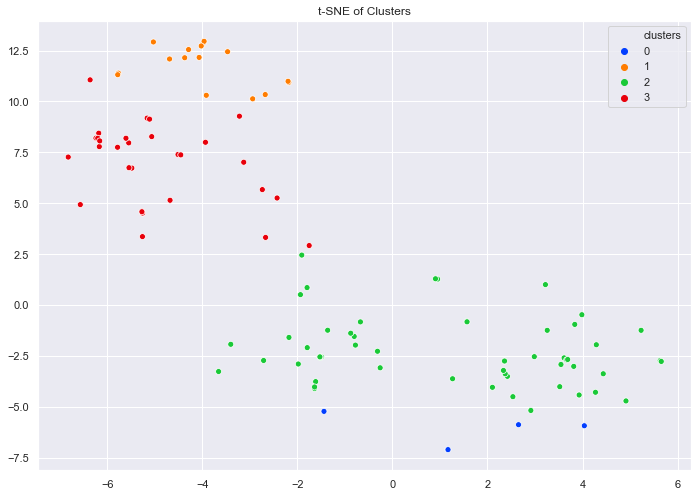

In [431]:
# T-SNE vizualization with clustering - TRY WITH REDUCED DATA SET WITH TRUNCATED SVD
tsne = TSNE(random_state=RANDOM, learning_rate=200, perplexity=25)
X_embedded = tsne.fit_transform(result)
palette = sns.color_palette("bright", 4)
y = clusters1['clusters']
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette).set_title('t-SNE of Clusters')

# Doesn't look much different to me - stick with 500 features

In [432]:
# Review the clusters in detail
c1 = clusters1[clusters1['clusters']==0]
#c1['titles'].sort_values()
print(c1['titles'].sort_values())
word_freq_df(c1)

# cluster 1 are jobs focused on business first and foremost - maybe at a higher strategic level?

32    Manager - Business Analysis - Small Business B...
76                              Senior Business Analyst
64                              Senior Business Manager
44    Sr. Business Manager - Small Business Card Mar...
49                Sr. Business Manager, Commercial Card
Name: titles, dtype: object
            frequency
business          117
drive              68
strategic          44
skills             41
marketing          34
new                33
develop            32
credit             31
product            30
environment        29
strategies         27
driveership        26
orientation        26
strong             25
products           25


In [433]:
c2 = clusters1[clusters1['clusters']==1]
print(c2['titles'].sort_values())
word_freq_df(c2)

# more traditional quant roles - banking, risk, credit, modeling

67                   Data Analysis Manager (McLean, VA)
0                                        Data Scientist
1                              Data Scientist, Card DS+
4              Data Scientist, Digital Machine Learning
2                   Data Scientist, Small Business Card
96                           Machine Learning Scientist
45         Machine Learning Scientist - Computer Vision
12      Machine Learning Scientist, Customer Resiliency
5                     Manager, Data Scientist, Card DS+
6     Principal Associate, Data Scientist - Small Bu...
3            Senior Associate, Data Scientist, Card DS+
7            Senior Associate, Data Scientist, Card DS+
11                                  Senior Data Analyst
17            Senior Data Analyst - University of Miami
9             Senior Manager, Data Science Tech College
89                            Sr. Data Analysis Manager
Name: titles, dtype: object
           frequency
data             189
least            100
business     

In [434]:
c3 = clusters1[clusters1['clusters']==2]
print(c3['titles'].sort_values())
word_freq_df(c3)
# data science roles

84                        BB Strategy - Business Manager
65     Business Analysis Manager - Marketing Attribut...
23     Business Analysis Manager - National Advertisi...
105                                    Business Director
41                                     Business Director
62           Business Director, Commercial Card - McLean
103                                     Business Manager
92                                      Business Manager
16                                      Business Manager
80                                      Business Manager
68                                      Business Manager
47                                      Business Manager
31                                      Business Manager
36                                      Business Manager
33              Business Manager - Anti Money Laundering
61     Business Manager - Commercial Card Channels Ma...
106               Business Manager - Small Business Card
18        Business Manager, Com

In [435]:
c4 = clusters1[clusters1['clusters']==3]
print(c4['titles'].sort_values())
word_freq_df(c4)

#outliers?

40      Business Director - Central Strategy & Analytics
28                 Business Manager, Customer Resiliency
42                    Business Manager, People Analytics
52                               Head of Talent Strategy
19              Manager, Quantitative Analysis -AEA 2020
35                        Manager, Quantitative Modeling
63      Principal Quantitative Analyst -Model Validation
56                        Principal Quantitative Modeler
34                        Principal Quantitative Modeler
20             Principal Quantitative Modeler – AEA 2020
72     Quantitative Analyst - Operational & Complianc...
13               Quantitative Researcher (United Income)
55     Research Scientist/Algorithm Developer  (Unite...
8      Senior Analyst, Quantitative Analysis -Trade A...
69                     Senior Data Engineer/Data Analyst
79     Senior Manager of Business Analysis, Card Mark...
48     Senior Manager, Business Analysis: Small Busin...
21     Senior Quantitative Anal

## Matrix 2 Hash Vectorization

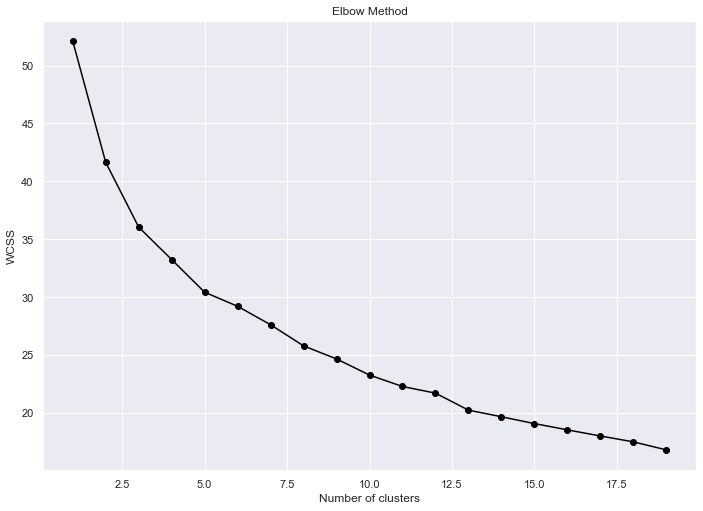

In [436]:
####### Matrix 2 Hash Vectorization ########
elbow_plot(hash_vect_df, 20)

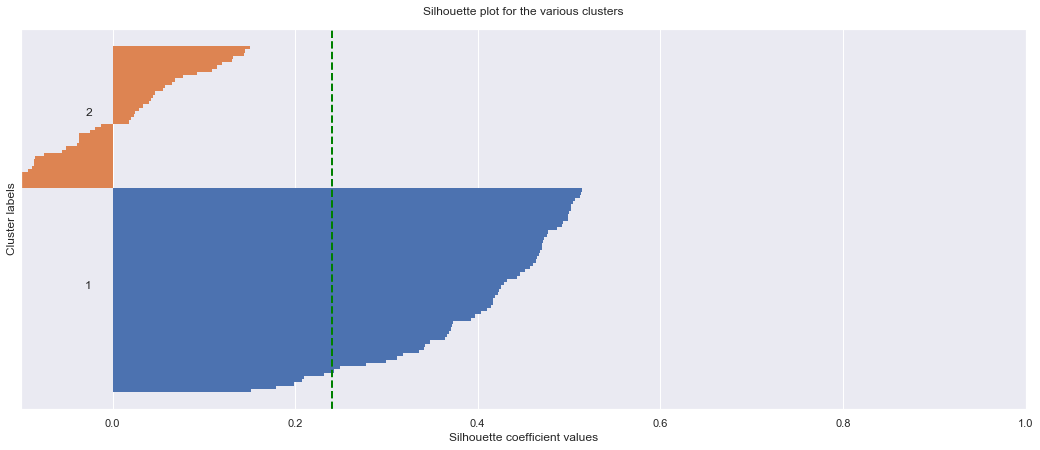

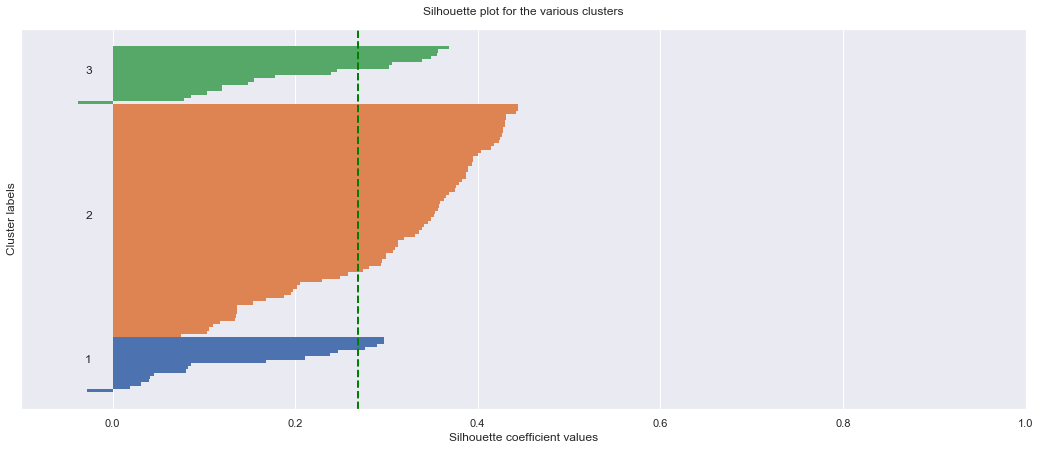

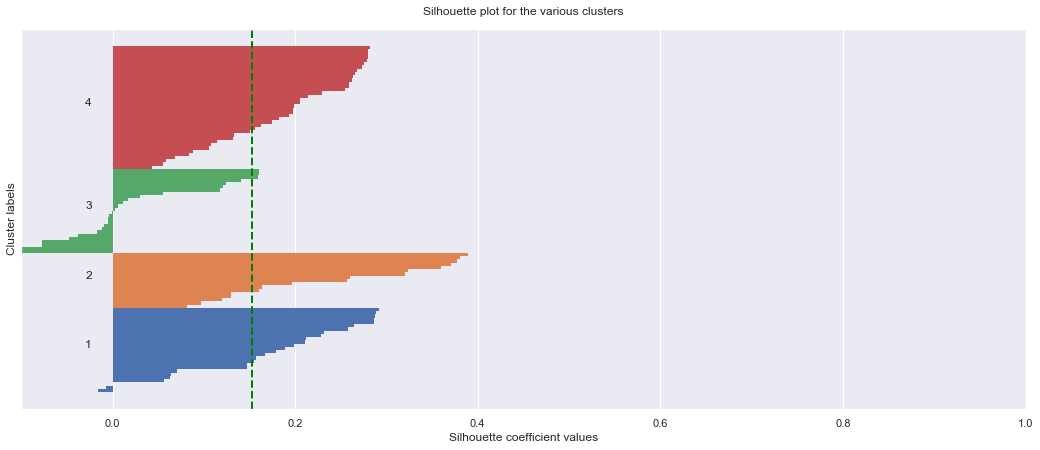

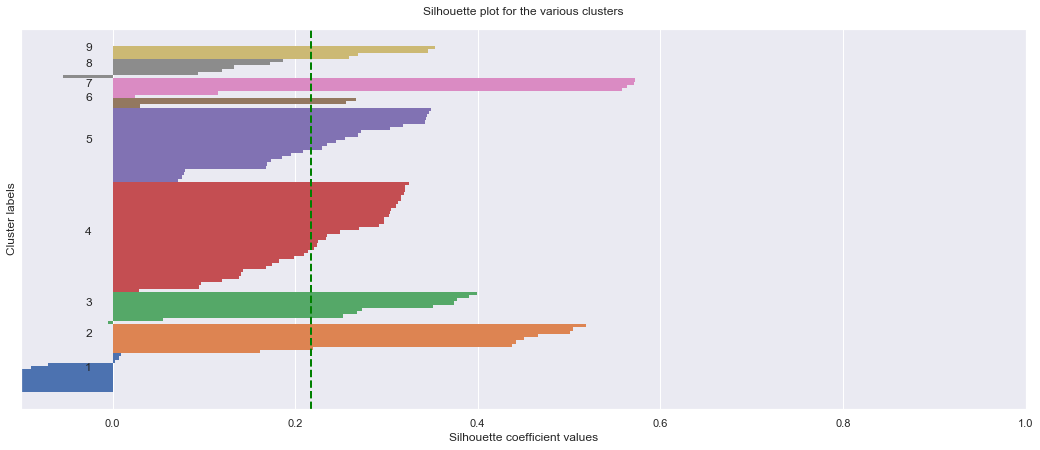

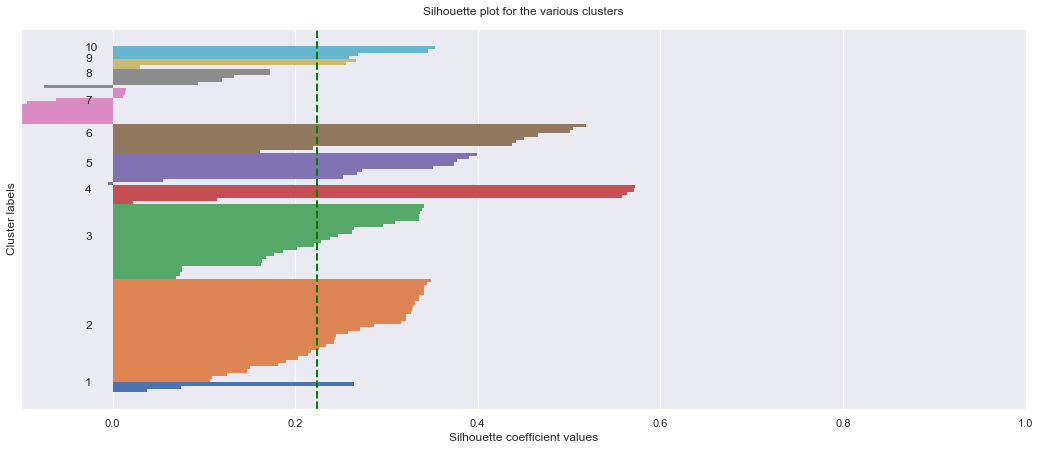

In [437]:
# Silhoutte plot
df = hash_vect_df
clust_range = [2,3,4,9, 10]
silhouette_samples_viz(df, clust_range)

# 2 and 4 clusters looks the best on elbow plot and silhouette plot

WCSS: 33.24126469459158


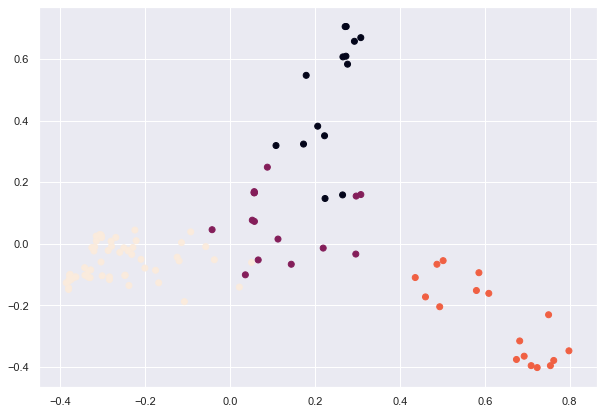

In [438]:
n_clusters=4
kmeans = KMeans(n_clusters, random_state=RANDOM).fit(hash_vect_df)
print('WCSS:', kmeans.inertia_)
labels = kmeans.labels_

princomp_scatter_color(hash_vect_df) # ugh change this color pallette - cant even see one cluster

In [439]:
# Create dataframe for exploration of clusters
clusters1 = hash_vect_df.copy()
clusters1['clusters']= labels #Glue back to original data
clusters1.reset_index(inplace=True)
clusters1 = clusters1.rename(columns={"index": "titles"})

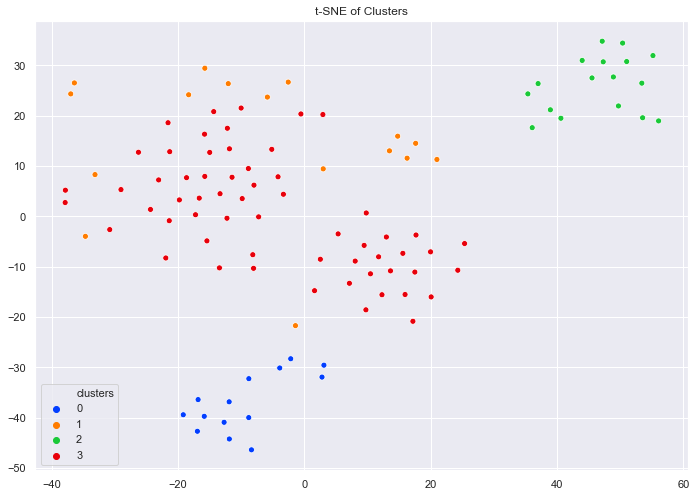

In [440]:
# T-SNE vizualization with clusterung
sns.set(rc={'figure.figsize':(11.7,8.27)})
tsne = TSNE(random_state=RANDOM, learning_rate=200, perplexity=22)

X_embedded = tsne.fit_transform(hash_vect_df)
palette = sns.color_palette("bright", 4)
y = clusters1['clusters']
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette).set_title('t-SNE of Clusters')
plt.savefig('tSNE_matrix2.png')
# Cluster 0 (data science jobs) and 2 (Quant/modeling jobs) are the only clear splits, although 3 (oddballs) are peppered
# throughout. Perhaps the split in the middle of the orange/red jobs is the split between manager and analyst level 
# business jobs?

In [441]:
c1 = clusters1[clusters1['clusters']==0]
print(c1['titles'].sort_values())
word_freq_df(c1)

# data science jobs

19             Manager, Quantitative Analysis -AEA 2020
35                       Manager, Quantitative Modeling
63     Principal Quantitative Analyst -Model Validation
34                       Principal Quantitative Modeler
56                       Principal Quantitative Modeler
20            Principal Quantitative Modeler – AEA 2020
72    Quantitative Analyst - Operational & Complianc...
8     Senior Analyst, Quantitative Analysis -Trade A...
21    Senior Quantitative Analyst -Trade Analytics a...
22    Senior Quantitative Analyst-Trade Analytics an...
54                   Sr. Manager, Quantitative Modeling
60                   Sr. Manager, Quantitative Modeling
66                             Sr. Quantitative Analyst
57                             Sr. Quantitative Modeler
Name: titles, dtype: object
                   frequency
advocacy              2.7634
customers enjoy      2.57964
influencing skills   2.51957
least year           1.74058
growth               1.43302
insight       

In [442]:
c2 = clusters1[clusters1['clusters']==1]
print(c2['titles'].sort_values())
word_freq_df(c2)
# jobs focused on business first and foremost - maybe at a higher stratefic level?

40      Business Director - Central Strategy & Analytics
28                 Business Manager, Customer Resiliency
52                               Head of Talent Strategy
13               Quantitative Researcher (United Income)
55     Research Scientist/Algorithm Developer  (Unite...
99                               Senior Business Manager
79     Senior Manager of Business Analysis, Card Mark...
48     Senior Manager, Business Analysis: Small Busin...
87                                  Sr. Business Analyst
93     Sr. Business Analyst - Credit & CLIP, Walmart ...
95     Sr. Business Analyst - Credit Infrastructure, ...
94     Sr. Business Analyst - Upgrades & Fraud, Walma...
97     Sr. Business Analyst - Valuations, Walmart Par...
88                                  Sr. Business Manager
101    Sr. Business Manager, Credit Risk Management, ...
91                           Sr. Business Manager, Fraud
Name: titles, dtype: object
                    frequency
clusters                   16


In [443]:
c3 = clusters1[clusters1['clusters']==2]
print(c3['titles'].sort_values())
word_freq_df(c3)

# quant and modeling

67                   Data Analysis Manager (McLean, VA)
0                                        Data Scientist
1                              Data Scientist, Card DS+
4              Data Scientist, Digital Machine Learning
2                   Data Scientist, Small Business Card
96                           Machine Learning Scientist
45         Machine Learning Scientist - Computer Vision
12      Machine Learning Scientist, Customer Resiliency
5                     Manager, Data Scientist, Card DS+
6     Principal Associate, Data Scientist - Small Bu...
7            Senior Associate, Data Scientist, Card DS+
3            Senior Associate, Data Scientist, Card DS+
11                                  Senior Data Analyst
17            Senior Data Analyst - University of Miami
69                    Senior Data Engineer/Data Analyst
9             Senior Manager, Data Science Tech College
89                            Sr. Data Analysis Manager
Name: titles, dtype: object
                    

In [444]:
c4 = clusters1[clusters1['clusters']==3]
print(c4['titles'].sort_values())
word_freq_df(c4)

# ????? odd balls

84                        BB Strategy - Business Manager
65     Business Analysis Manager - Marketing Attribut...
23     Business Analysis Manager - National Advertisi...
105                                    Business Director
41                                     Business Director
62           Business Director, Commercial Card - McLean
47                                      Business Manager
16                                      Business Manager
103                                     Business Manager
92                                      Business Manager
68                                      Business Manager
80                                      Business Manager
31                                      Business Manager
36                                      Business Manager
33              Business Manager - Anti Money Laundering
61     Business Manager - Commercial Card Channels Ma...
106               Business Manager - Small Business Card
18        Business Manager, Com

## Matrix 3 TF-IDF

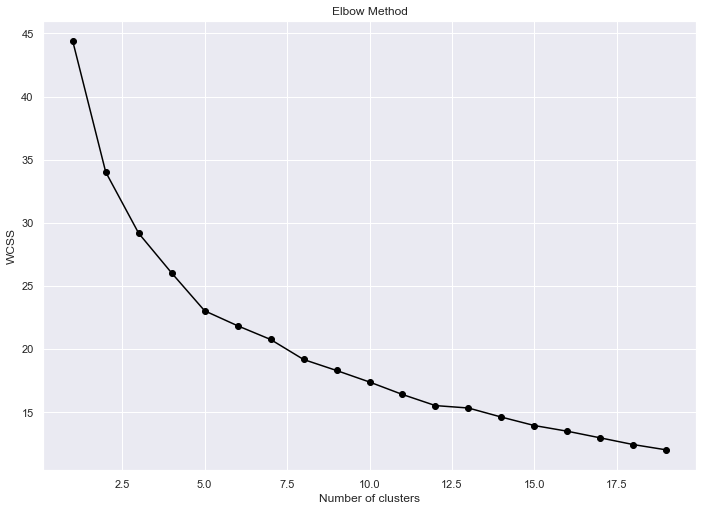

In [445]:
##### Matrix 3 TF-IDF Vectorization #####
elbow_plot(matrix, 20)

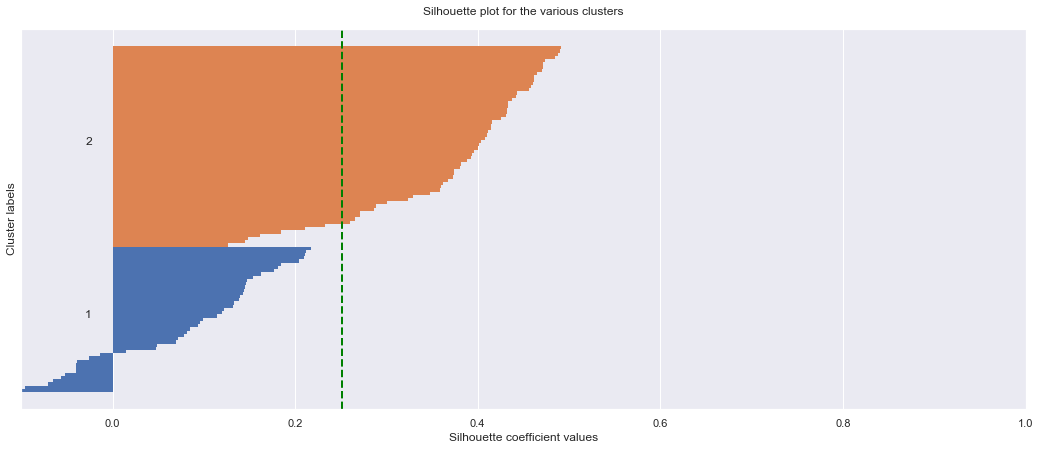

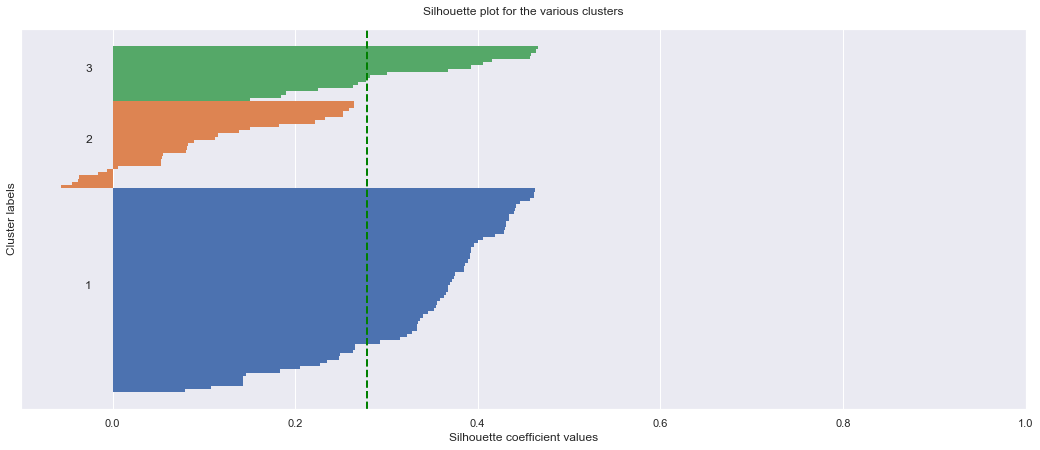

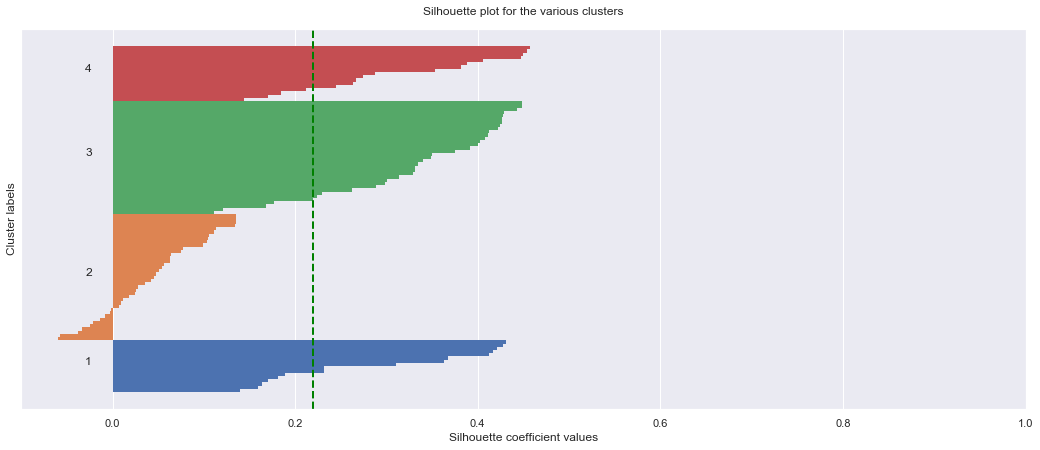

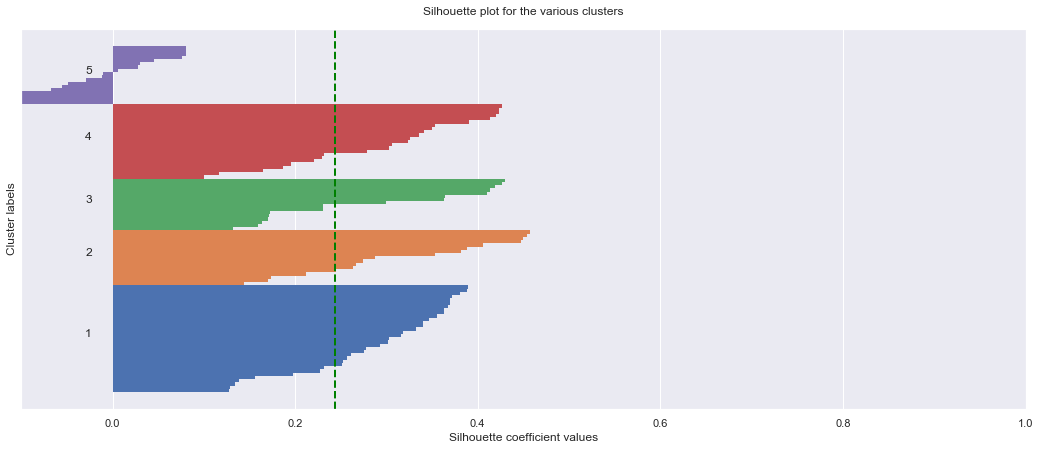

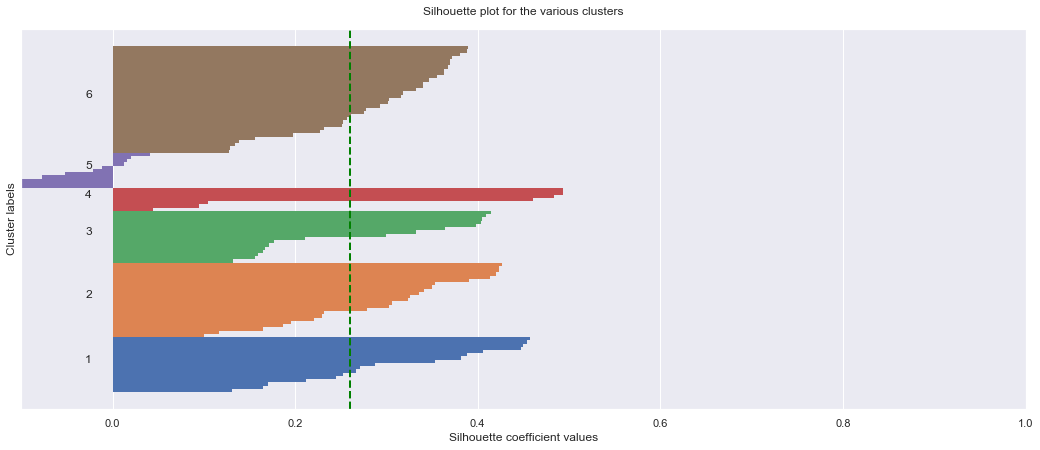

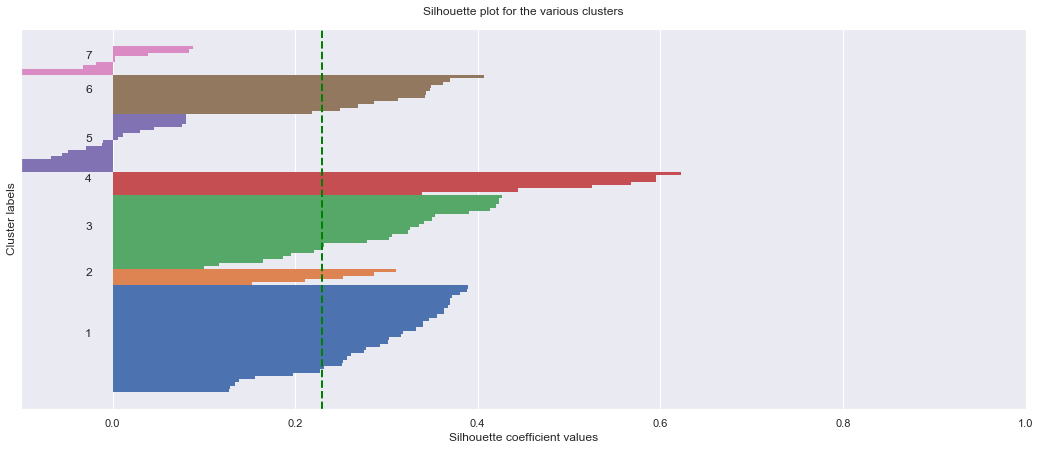

In [446]:
# Silhoutte plot
df = matrix
clust_range = [2,3,4, 5, 6, 7]
silhouette_samples_viz(df, clust_range)

# 5 clusters looks the best on elbow plot and silhouette plot - although that one cluster is terrible

WCSS: 23.02357880269236


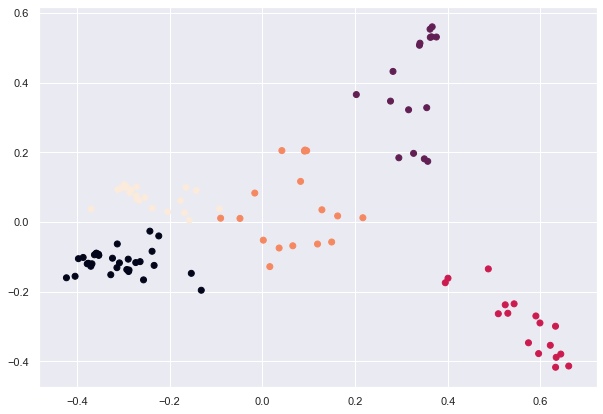

In [447]:
n_clusters=5
kmeans = KMeans(n_clusters, random_state=RANDOM).fit(matrix)
print('WCSS:', kmeans.inertia_)
labels = kmeans.labels_

princomp_scatter_color(matrix)
#PCA of count vectorizer


In [448]:
# Create dataframe for exploration of clusters
clusters1 = matrix.copy()
# #Glue back to original data
clusters1['clusters']= labels
clusters1.reset_index(inplace=True)
clusters1 = clusters1.rename(columns={"index": "titles"})


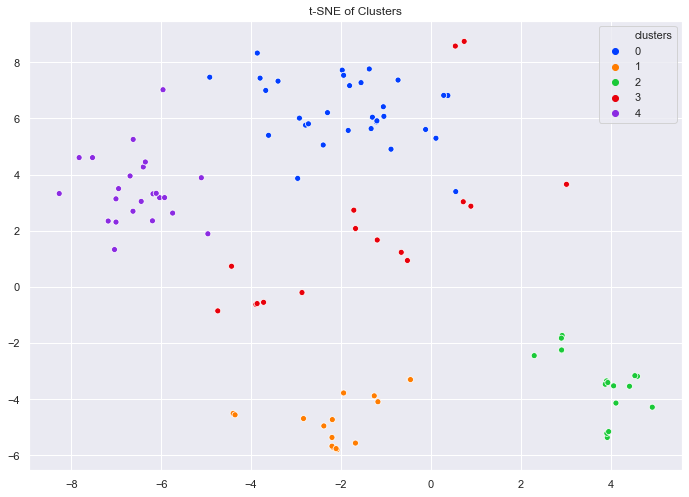

In [450]:
# T-SNE vizualization with clusterung
sns.set(rc={'figure.figsize':(11.7,8.27)})
tsne = TSNE(random_state=RANDOM, learning_rate=200, perplexity=29)

X_embedded = tsne.fit_transform(matrix)
palette = sns.color_palette("bright", 5) # change based on number of clusters
y = clusters1['clusters']
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette).set_title('t-SNE of Clusters')
plt.savefig('tSNE_matrix3.png')
# Green = DS, Orange = analyst business roles, Purple=odd ball, Blue = higher level bus roles, # Red= quant/modeler roles
# So far, TF-IDF seems to do the best job modeling the groups

In [451]:
c1 = clusters1[clusters1['clusters']==0]
print(c1['titles'].sort_values())
word_mean_df(c1)

# busines at a higher level - strategic, leadership, etc

84                        BB Strategy - Business Manager
65     Business Analysis Manager - Marketing Attribut...
23     Business Analysis Manager - National Advertisi...
105                                    Business Director
41                                     Business Director
62           Business Director, Commercial Card - McLean
16                                      Business Manager
103                                     Business Manager
31                                      Business Manager
92                                      Business Manager
36                                      Business Manager
80                                      Business Manager
68                                      Business Manager
47                                      Business Manager
33              Business Manager - Anti Money Laundering
61     Business Manager - Commercial Card Channels Ma...
106               Business Manager - Small Business Card
18        Business Manager, Com

In [452]:
c2 = clusters1[clusters1['clusters']==1]
print(c2['titles'].sort_values())
word_mean_df(c2)

# data science

19             Manager, Quantitative Analysis -AEA 2020
35                       Manager, Quantitative Modeling
63     Principal Quantitative Analyst -Model Validation
34                       Principal Quantitative Modeler
56                       Principal Quantitative Modeler
20            Principal Quantitative Modeler – AEA 2020
72    Quantitative Analyst - Operational & Complianc...
13              Quantitative Researcher (United Income)
55    Research Scientist/Algorithm Developer  (Unite...
8     Senior Analyst, Quantitative Analysis -Trade A...
21    Senior Quantitative Analyst -Trade Analytics a...
22    Senior Quantitative Analyst-Trade Analytics an...
54                   Sr. Manager, Quantitative Modeling
60                   Sr. Manager, Quantitative Modeling
66                             Sr. Quantitative Analyst
57                             Sr. Quantitative Modeler
Name: titles, dtype: object
                  mean
clusters      1.000000
modeling      0.233707
model  

In [453]:
c3 = clusters1[clusters1['clusters']==2]
print(c3['titles'].sort_values())
word_mean_df(c3)
# quant and modeling

67                   Data Analysis Manager (McLean, VA)
0                                        Data Scientist
1                              Data Scientist, Card DS+
4              Data Scientist, Digital Machine Learning
2                   Data Scientist, Small Business Card
96                           Machine Learning Scientist
45         Machine Learning Scientist - Computer Vision
12      Machine Learning Scientist, Customer Resiliency
5                     Manager, Data Scientist, Card DS+
6     Principal Associate, Data Scientist - Small Bu...
7            Senior Associate, Data Scientist, Card DS+
3            Senior Associate, Data Scientist, Card DS+
11                                  Senior Data Analyst
17            Senior Data Analyst - University of Miami
69                    Senior Data Engineer/Data Analyst
9             Senior Manager, Data Science Tech College
89                            Sr. Data Analysis Manager
Name: titles, dtype: object
                  me

In [454]:
c4 = clusters1[clusters1['clusters']==3]
print(c4['titles'].sort_values())
word_mean_df(c4)

40      Business Director - Central Strategy & Analytics
28                 Business Manager, Customer Resiliency
42                    Business Manager, People Analytics
52                               Head of Talent Strategy
58             Senior Business Analyst - Commercial Bank
51     Senior Business Analyst - Commercial Card Stra...
99                               Senior Business Manager
79     Senior Manager of Business Analysis, Card Mark...
48     Senior Manager, Business Analysis: Small Busin...
87                                  Sr. Business Analyst
102                                 Sr. Business Analyst
93     Sr. Business Analyst - Credit & CLIP, Walmart ...
95     Sr. Business Analyst - Credit Infrastructure, ...
94     Sr. Business Analyst - Upgrades & Fraud, Walma...
97     Sr. Business Analyst - Valuations, Walmart Par...
88                                  Sr. Business Manager
101    Sr. Business Manager, Credit Risk Management, ...
91                           Sr

In [455]:
c5 = clusters1[clusters1['clusters']==4]
print(c5['titles'].sort_values())
word_mean_df(c5)

# Business but lower level?

30                     Senior Associate Business Analyst
10                               Senior Business Analyst
76                               Senior Business Analyst
59                               Senior Business Analyst
104                              Senior Business Analyst
86        Senior Business Analyst (Acquisition Strategy)
24     Senior Business Analyst - Bank Account Opening...
25             Senior Business Analyst - Market Research
77     Senior Business Analyst - Ongoing Engagement C...
37            Senior Business Analyst - People Analytics
75         Senior Business Analyst - Pricing & Economics
29         Senior Business Analyst - Small Business Card
26     Senior Business Analyst - Small Business Card ...
53     Sr Associate Business Analyst - Deposit Pricin...
81                                   Sr Business Analyst
98                                  Sr. Business Analyst
14                                  Sr. Business Analyst
100                            

## Matrix 4 Doc2Vec

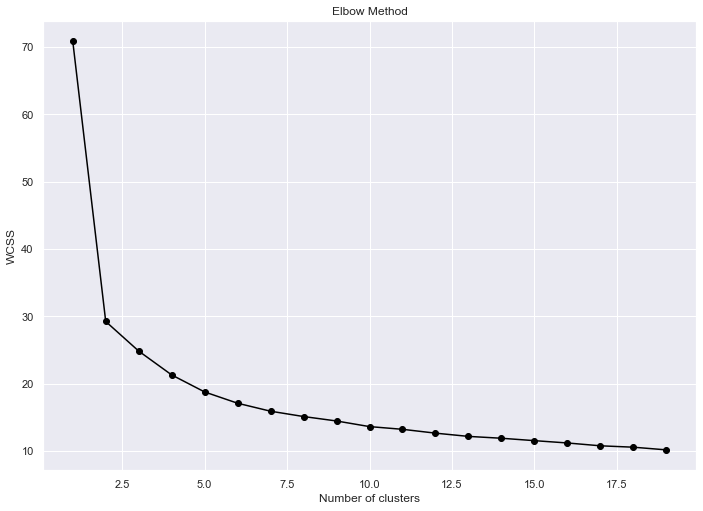

In [456]:
##### Matrix 4 Doc2Vec  #####
elbow_plot(doc2vec_df, 20)

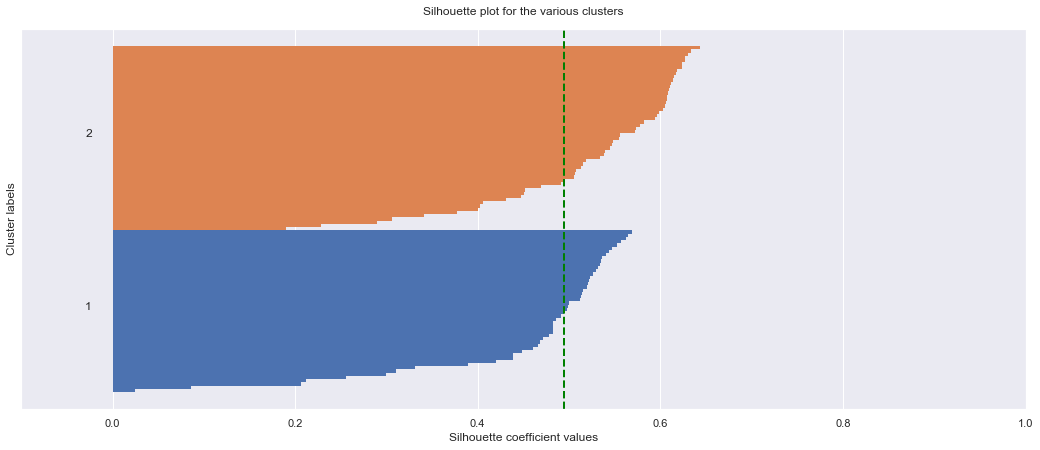

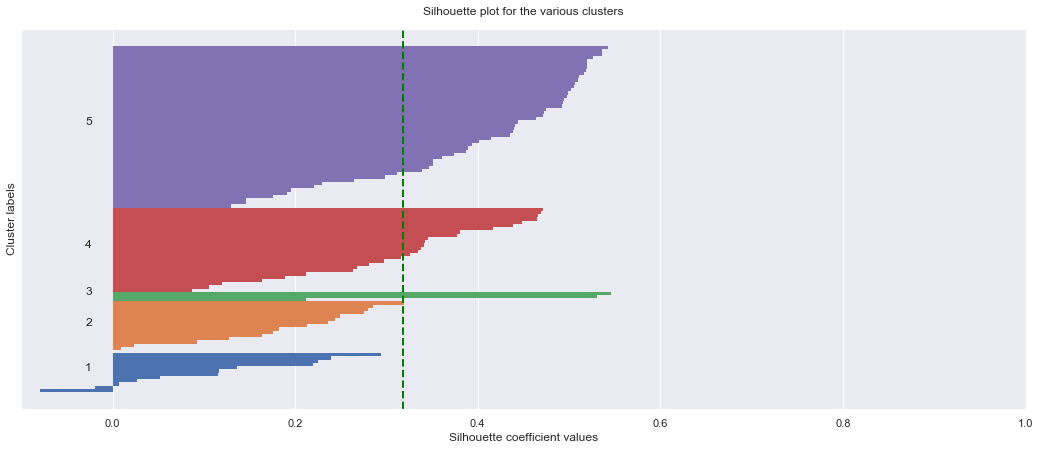

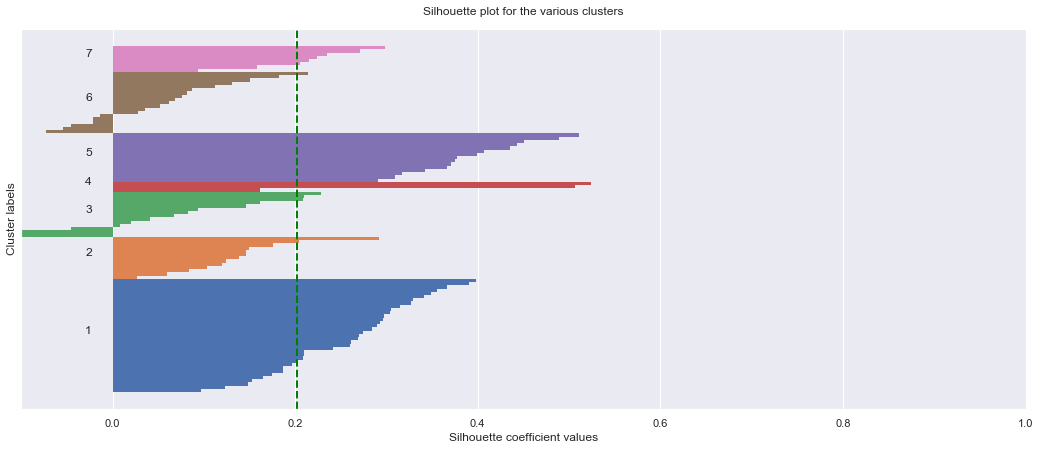

In [457]:
# Silhoutte plot
df = doc2vec_df
clust_range = [2, 5, 7]
silhouette_samples_viz(df, clust_range)

# 2 and 5 clusters looks the best on elbow plot and silhouette plot

WCSS: 29.22845427287774


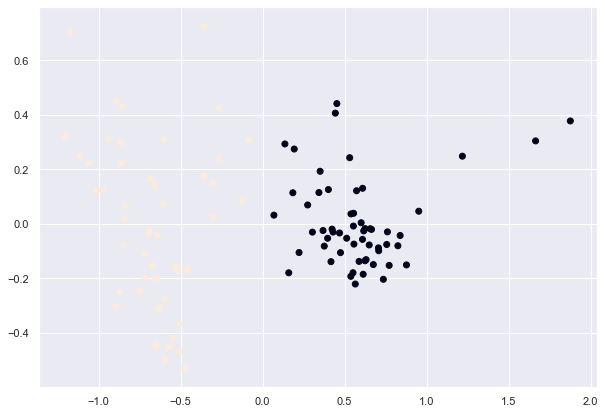

In [458]:
n_clusters=2
kmeans = KMeans(n_clusters, random_state=RANDOM).fit(doc2vec_df)
print('WCSS:', kmeans.inertia_)
labels = kmeans.labels_

princomp_scatter_color(doc2vec_df)

In [459]:
# Create dataframe for exploration of clusters
clusters1 = doc2vec_df.copy()
# #Glue back to original data
clusters1['clusters']= labels
clusters1.reset_index(inplace=True)
clusters1 = clusters1.rename(columns={"index": "titles"})



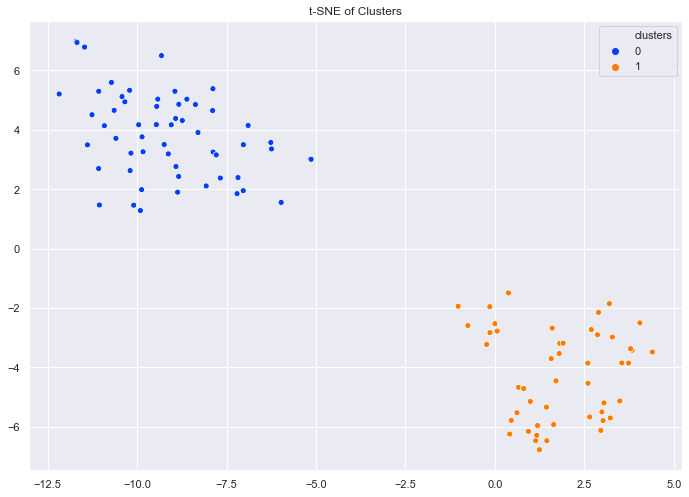

In [461]:
# T-SNE vizualization with clusterung
sns.set(rc={'figure.figsize':(11.7,8.27)})
tsne = TSNE(random_state=RANDOM, learning_rate=250, perplexity=30)

X_embedded = tsne.fit_transform(doc2vec_df)
palette = sns.color_palette("bright", 2) # change based on number of clusters
y = clusters1['clusters']
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette).set_title('t-SNE of Clusters')
plt.savefig('tSNE_matrix4.png')
# Green = DS, Orange = analyst business roles, Purple=odd ball, Blue = higher level bus roles, # Red= quant/modeler roles
# So far, TF-IDF seems to do the best job modeling the groups

In [132]:
c1 = clusters1[clusters1['clusters']==0]
print(c1['title'].sort_values())
# Data science, quant modeling, and specific areas

84                        BB Strategy - Business Manager
65     Business Analysis Manager - Marketing Attribut...
23     Business Analysis Manager - National Advertisi...
105                                    Business Director
41                                     Business Director
62           Business Director, Commercial Card - McLean
103                                     Business Manager
92                                      Business Manager
16                                      Business Manager
80                                      Business Manager
68                                      Business Manager
47                                      Business Manager
31                                      Business Manager
36                                      Business Manager
33              Business Manager - Anti Money Laundering
61     Business Manager - Commercial Card Channels Ma...
106               Business Manager - Small Business Card
18        Business Manager, Com

In [133]:
c2 = clusters1[clusters1['clusters']==1]
print(c2['title'].sort_values())
# More traditional and general business rolse

40      Business Director - Central Strategy & Analytics
28                 Business Manager, Customer Resiliency
42                    Business Manager, People Analytics
67                    Data Analysis Manager (McLean, VA)
0                                         Data Scientist
1                               Data Scientist, Card DS+
4               Data Scientist, Digital Machine Learning
2                    Data Scientist, Small Business Card
52                               Head of Talent Strategy
96                            Machine Learning Scientist
45          Machine Learning Scientist - Computer Vision
12       Machine Learning Scientist, Customer Resiliency
5                      Manager, Data Scientist, Card DS+
19              Manager, Quantitative Analysis -AEA 2020
35                        Manager, Quantitative Modeling
6      Principal Associate, Data Scientist - Small Bu...
63      Principal Quantitative Analyst -Model Validation
34                        Princ

## Clustering & MDS results

All four methods seemed to agree that the documents could be split into two clusters or 4 or 5 groups. I chose the number of clusters for each matrix based on how much sense the job titles (and word importance) made within each cluster. The groups are described below:

__Count and Hash vectorizer__- Four clusters: 1) traditional business roles (banking, risk, credit) was the largest group, 2) data science jobs, 3) quant and modeling jobs, and 4) a small odd ball group of jobs.

__TF-IDF__- Five clusters: 1) More senior/manager traditional business roles (banking, risk, credit) 2) More junior/analyst traditional business roles 3) data science jobs, 4) quant and modeling jobs, and 5) a small odd ball group of jobs.

__Doc2Vec__- Two clusters: 1) traditional business roles (banking, risk, credit) and 2) Data science, quant, modeling roles


TF-IDF seems to do the best job delineating the jobs into 5 categories, splitting the large "traditional business roles" into two groups based on seemingly more "manager" type roles and more "analyst" type rolse. The first three approaches all cluster data science and more traditional modeling/quant roles out nicely. The t-SNE visualization does the best to separate the two clusters in the Doc2Vec approach.

One limitation to this analysis is that I am mainly judging my assessment based on job title, whereas I know the text varies within each role. I was able to analyze this a bit by the top words in each cluster. The job titles do vary (85 different titles out of 107 jobs), but they are included in the job descriptions and may be repeated throughout...."As a business analyst you will do this..." This could be affecting the results when like-named jobs are grouped together.


# MDS with terms as objects

Using matrices for Approaches 1 and 2, perform multidimensional scaling (t-SNE) with terms as objects. Visualize the multidimensional scaling solutions in two-space, labeling points as terms. Describe the results.

In [476]:
# Change the vector length for this part of assignment
# Cannot plot 500 words on t-SNE plot - or take just a sample?
MAX_NGRAM_LENGTH = 1
VECTOR_LENGTH=150

In [477]:
######### MATRIX 1 - Count Vectorization using max vocab words #########

count_vectorizer = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
count_vectors = count_vectorizer.fit_transform(final_processed_text)

count_vect_df = pd.DataFrame(count_vectors.todense(), columns=count_vectorizer.get_feature_names(), index=job_labels)

# Transpose the df so terms are the rows
count_vect_df_T = count_vect_df.transpose()
#count_vect_df_T.head()

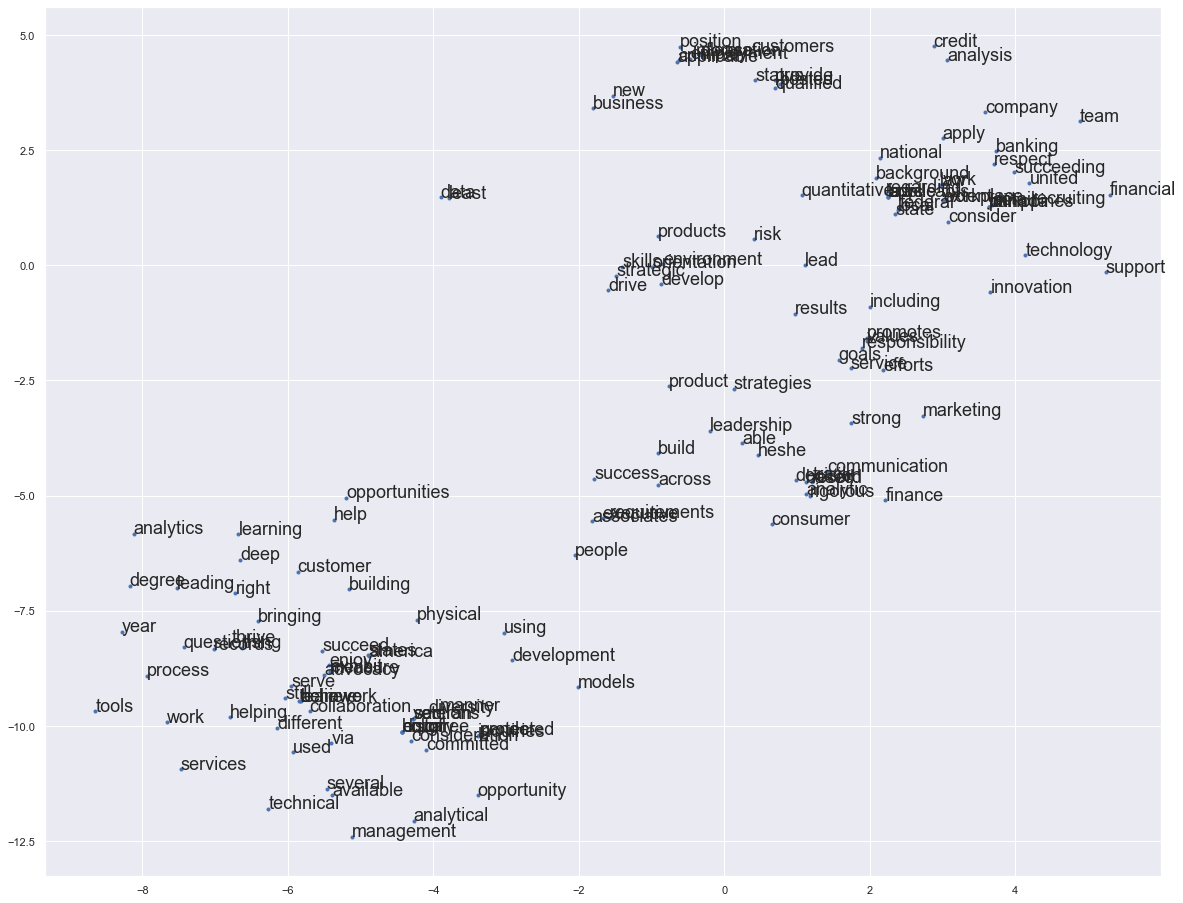

In [487]:
# T-SNE vizualization with clusterung
tsne = TSNE(random_state=RANDOM, learning_rate=300, perplexity=30)
X_embedded = tsne.fit_transform(count_vect_df_T)

plt.figure(figsize = (20, 16))
plt.scatter(X_embedded[:,0], X_embedded[:,1], marker = '.')
words = list(count_vect_df_T.index)
for i, word in enumerate(words):
    plt.annotate(word, size=18, xy=(X_embedded[i, 0], X_embedded[i, 1]))
plt.savefig('tSNE_WORDS_matrix1.png')
plt.show()


In [479]:
######### MATRIX 2 Hashing Vectorization #########
hashing_vectorizer = HashingVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), n_features = VECTOR_LENGTH)
hashing_vectors = hashing_vectorizer.fit_transform(final_processed_text)
hash_vect_df = pd.DataFrame(hashing_vectors.todense(), columns=count_vectorizer.get_feature_names(), index=labels)

# Transpose the df so terms are the rows
hash_vect_df_T = hash_vect_df.transpose()


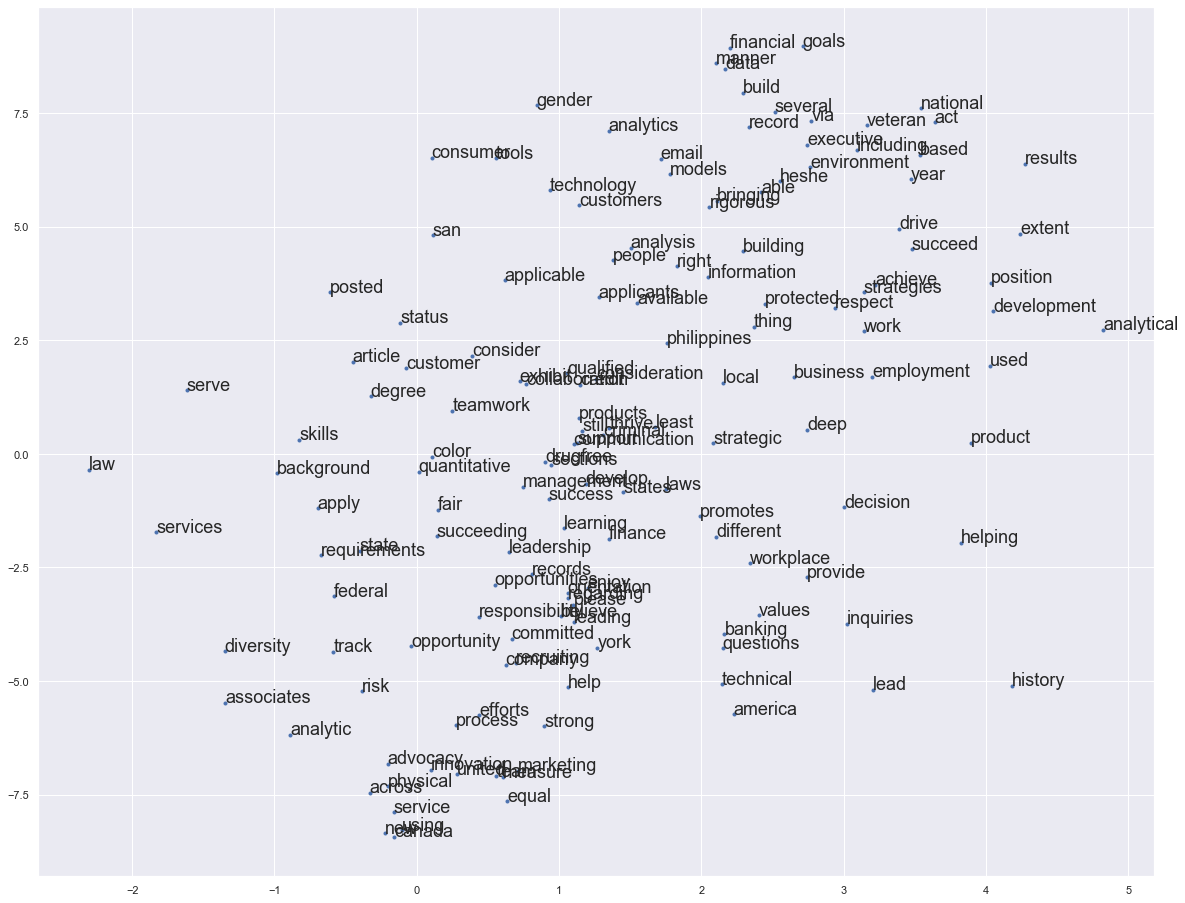

In [486]:
# T-SNE vizualization with clustering
tsne = TSNE(random_state=RANDOM, learning_rate=250, perplexity=35)
X_embedded = tsne.fit_transform(hash_vect_df_T)

plt.figure(figsize = (20, 16))
plt.scatter(X_embedded[:,0], X_embedded[:,1], marker = '.')
words = list(hash_vect_df_T.index)
for i, word in enumerate(words):
    plt.annotate(word,  size=18, xy=(X_embedded[i, 0], X_embedded[i, 1]))
#plt.savefig('tSNE_WORDS_matrix2.png')
plt.show()

In [481]:
####### MATRIX 3 - TF-IDF Vectorization #########
# Basic cleans for TF-IDF (different than Count vectorization)
from nltk.corpus import stopwords

# Function to clean documents
def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    # # filter out short tokens
    #tokens = [word for word in tokens if len(word) > 1]
    # #lowercase all words
    tokens = [word.lower() for word in tokens]  
    stop_words = list(stopwords.words('english'))
    stop_words.append('capital')
    stop_words.append('one')
    stop_words.append('years')
    stop_words.append('experience')
    stop_words.append('years experience')
    stop_words.append('captial one')
    stop_words.append('mclean')
    tokens = [w for w in tokens if not w in stop_words]         
    # # word stemming Commented
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens

# Prepare Entire Data Set for TF-IDF
data = data
text_body=[]
for i in range(0,len(data)):
    temp_text=data['text'].iloc[i]
    text_body.append(temp_text)
    
processed_text=[]
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)
    
final_processed_text=[]
for i in processed_text:
    temp_DSI=" ".join(str(item) for item in i )
    final_processed_text.append(temp_DSI)
    

In [482]:
### Sklearn TFIDF 
Tfidf=TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
TFIDF_matrix=Tfidf.fit_transform(final_processed_text)     
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns = Tfidf.get_feature_names(), index=labels)
# Transpose the df so terms are the rows
matrix_T = matrix.transpose()
matrix_T.head()

1         1         1         1         1         1  \
able      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
achieve   0.035643  0.030514  0.032841  0.025894  0.028574  0.025246   
across    0.044179  0.075644  0.081412  0.064189  0.106251  0.062583   
act       0.071287  0.061029  0.065682  0.051787  0.057148  0.050491   
advocacy  0.035643  0.030514  0.032841  0.025894  0.028574  0.025246   

                 1         1         1         1  ...         1         0  \
able      0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.096598   
achieve   0.029697  0.027129  0.043026  0.027382  ...  0.038528  0.032691   
across    0.073619  0.100877  0.000000  0.033940  ...  0.000000  0.040520   
act       0.059395  0.054258  0.086051  0.054764  ...  0.077056  0.065382   
advocacy  0.029697  0.027129  0.043026  0.027382  ...  0.038528  0.032691   

                 1         0         1         0         0         0  \
able      0.155998  0.091092  0.037382  0.109875  0.134921  0.097066   
achieve   0.070391  0.030828  0.025302  0.037184  0.030440  0.032849   
across    0.218122  0.038210  0.031362  0.000000  0.075460  0.040716   
act       0.070391  0.061655  0.050604  0.074368  0.060881  0.065699   
advocacy  0.035196  0.030828  0.025302  0.037184  0.030440  0.032849   

                 0         0  
able      0.134504  0.124185  
achieve   0.030346  0.028018  
across    0.075227  0.069456  
act       0.060692  0.056036  
advocacy  0.030346  0.028018  

[5 rows x 107 columns]

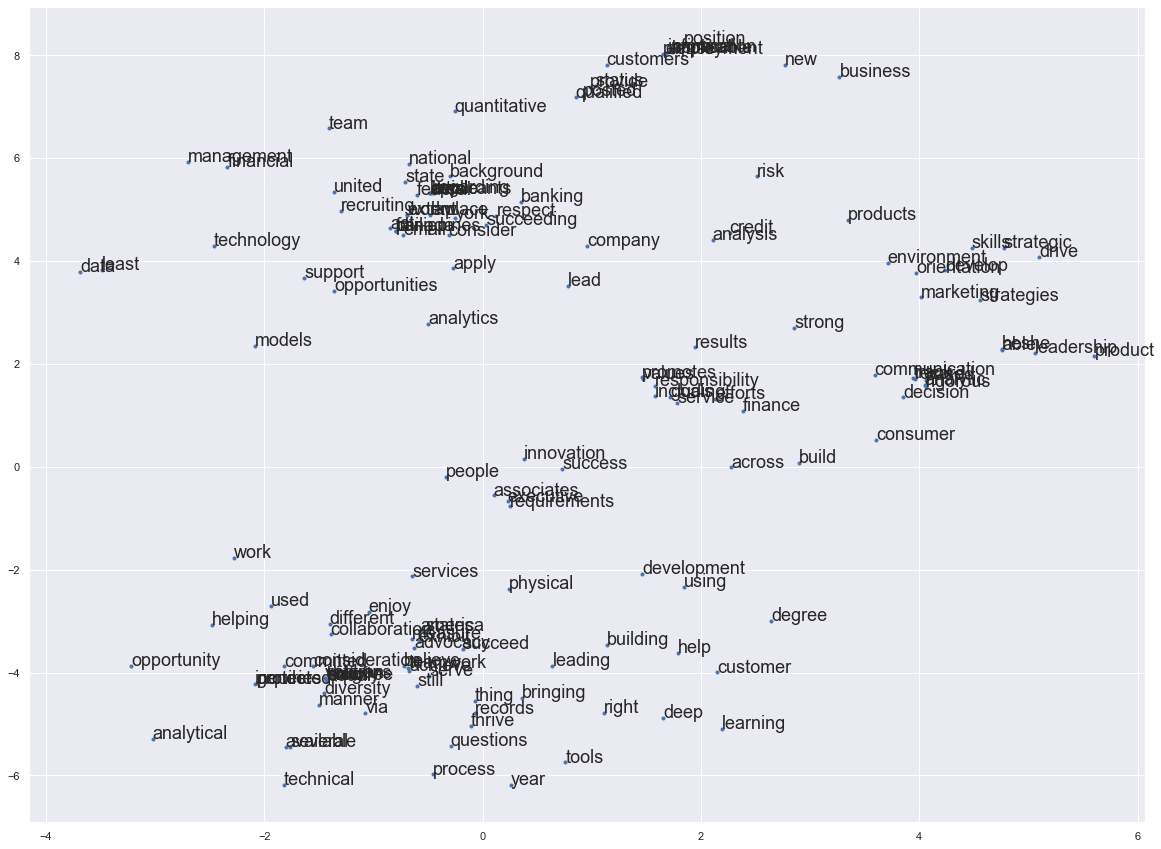

In [483]:
# T-SNE vizualization with clustering
tsne = TSNE(random_state=RANDOM, learning_rate=250, perplexity=35)
X_embedded = tsne.fit_transform(matrix_T)

plt.figure(figsize = (20, 15))
plt.scatter(X_embedded[:,0], X_embedded[:,1], marker = '.')
words = list(matrix_T.index)
for i, word in enumerate(words):
    plt.annotate(word, size=18, xy=(X_embedded[i, 0], X_embedded[i, 1]))
plt.savefig('tSNE_WORDS_matrix3.png')
plt.show()


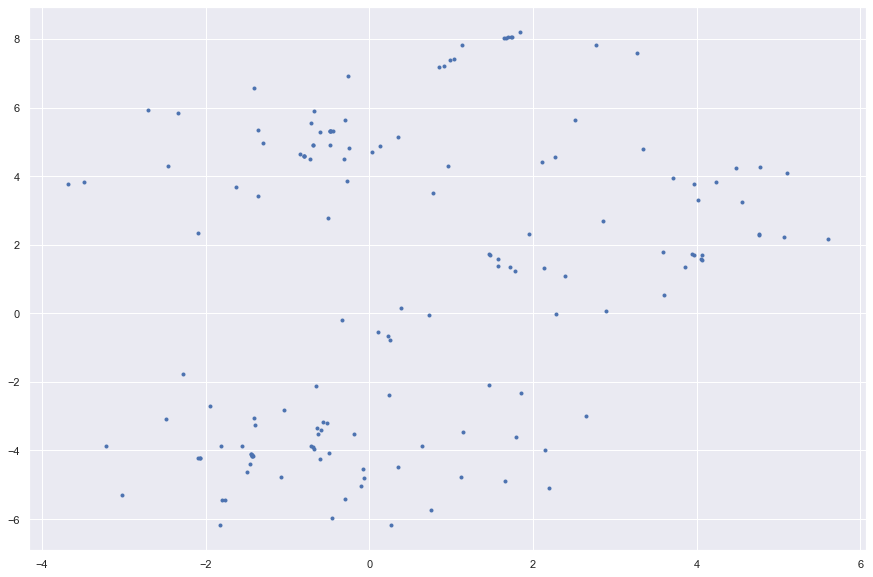

In [153]:
# without labels
plt.figure(figsize = (15, 10))
plt.scatter(X_embedded[:,0], X_embedded[:,1], marker = '.')
words = list(matrix_T.index)
# for i, word in enumerate(words):
#     pyplot.annotate(word, size=18, xy=(X_embedded[i, 0], X_embedded[i, 1]))
plt.show()

## MDS with terms as object results

Generally its hard to make sense of the t-SNE visualizations with thte terms printed. The goal of t-SNE is to get the data clearly separated into groups. None of my vectors produced great results in terms of clusterings. I do see some terms clustered together that go together and makes sense, but I see many more groupings that don't necessarily make sense to me.

# Hierarchical cluster analysis with terms as objects

Using matrices for Approaches 1 and 2, perform hierarchical cluster analysis with terms as objects. Visualize the clustering solution as a tree diagram, with terminal nodes labeled as terms. Describe the results.

Agglomerative procedures are widely used. Produce a series of partitions in the data: the first consisted of n-single member 'clusters'; the last consists of a single group containing all n individuals. 

What distance to use?
 - Euclidean -  most commonly used and is the same measurement used in MDS above, so we can compare resules
 - City-block/Manhattan
 - Correlation
 
 What linkage to use? 
  - single
  - complete - maximum distance between objects
  - average - tends to join clusters with small variances. Takes account of cluster structure. Relatively robust.
  - centroid
  - weighted average
  - median
  - Ward's method - sensitive to outliers, tends to find same-size spherical clusters


In [492]:
# Change the vector length for this part of assignment
# Cannot plot 500 words on t-SNE plot - or take just a sample?
MAX_NGRAM_LENGTH = 1
VECTOR_LENGTH=150

In [493]:
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as shc

In [494]:
#### Matrix 1 #####
count_vectorizer = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
count_vectors = count_vectorizer.fit_transform(final_processed_text)
count_vect_df = pd.DataFrame(count_vectors.todense(), columns=count_vectorizer.get_feature_names(), index=job_labels)

In [495]:
count_vect_df

able  achieve  across  act  \
Data Scientist                                 0        1       1    2   
Data Scientist, Card DS+                       0        1       2    2   
Data Scientist, Small Business Card            0        1       2    2   
Senior Associate, Data Scientist, Card DS+     0        1       2    2   
Data Scientist, Digital Machine Learning       0        1       3    2   
...                                          ...      ...     ...  ...   
Sr. Business Analyst                           2        1       0    2   
Business Manager                               3        1       2    2   
Senior Business Analyst                        2        1       1    2   
Business Director                              3        1       2    2   
Business Manager - Small Business Card         3        1       2    2   

                                            advocacy  america  analysis  \
Data Scientist                                     1        1         1   
Data Scientist, Card DS+                           1        1         1   
Data Scientist, Small Business Card                1        1         1   
Senior Associate, Data Scientist, Card DS+         1        1         1   
Data Scientist, Digital Machine Learning           1        1         1   
...                                              ...      ...       ...   
Sr. Business Analyst                               1        1         0   
Business Manager                                   1        1         3   
Senior Business Analyst                            1        1         5   
Business Director                                  1        1         2   
Business Manager - Small Business Card             1        2         3   

                                            analytic  analytical  analytics  \
Data Scientist                                     0           0          1   
Data Scientist, Card DS+                           0           0          2   
Data Scientist, Small Business Card                0           0          1   
Senior Associate, Data Scientist, Card DS+         0           0          2   
Data Scientist, Digital Machine Learning           0           0          3   
...                                              ...         ...        ...   
Sr. Business Analyst                               1           1          3   
Business Manager                                   2           1          1   
Senior Business Analyst                            2           1          1   
Business Director                                  2           1          1   
Business Manager - Small Business Card             2           1          1   

                                            ...  united  used  using  values  \
Data Scientist                              ...       2     1      3       1   
Data Scientist, Card DS+                    ...       2     1      3       1   
Data Scientist, Small Business Card         ...       2     1      3       1   
Senior Associate, Data Scientist, Card DS+  ...       2     1      3       1   
Data Scientist, Digital Machine Learning    ...       2     1      4       1   
...                                         ...     ...   ...    ...     ...   
Sr. Business Analyst                        ...       2     1      0       2   
Business Manager                            ...       2     1      1       2   
Senior Business Analyst                     ...       2     1      2       2   
Business Director                           ...       2     1      1       2   
Business Manager - Small Business Card      ...       3     1      1       2   

                                            veteran  via  work  workplace  \
Data Scientist                                    1    1     2          2   
Data Scientist, Card DS+                          1    1     2          2   
Data Scientist, Small Business Card               1    1     2          2   
Senior Associate, Data Scientist, Ca

In [496]:
# Scale the data
data_scaled = normalize(count_vect_df)
data_scaled = pd.DataFrame(data_scaled, columns=count_vect_df.columns)
data_scaled.head()

able   achieve    across       act  advocacy   america  analysis  analytic  \
0   0.0  0.039746  0.039746  0.079493  0.039746  0.039746  0.039746       0.0   
1   0.0  0.035737  0.071474  0.071474  0.035737  0.035737  0.035737       0.0   
2   0.0  0.036860  0.073721  0.073721  0.036860  0.036860  0.036860       0.0   
3   0.0  0.031766  0.063532  0.063532  0.031766  0.031766  0.031766       0.0   
4   0.0  0.033962  0.101885  0.067924  0.033962  0.033962  0.033962       0.0   

   analytical  analytics  ...    united      used     using    values  \
0         0.0   0.039746  ...  0.079493  0.039746  0.119239  0.039746   
1         0.0   0.071474  ...  0.071474  0.035737  0.107211  0.035737   
2         0.0   0.036860  ...  0.073721  0.036860  0.110581  0.036860   
3         0.0   0.063532  ...  0.063532  0.031766  0.095298  0.031766   
4         0.0   0.101885  ...  0.067924  0.033962  0.135847  0.033962   

    veteran       via      work  workplace      year      york  
0  0.039746  0.039746  0.079493   0.079493  0.119239  0.079493  
1  0.035737  0.035737  0.071474   0.071474  0.107211  0.071474  
2  0.036860  0.036860  0.073721   0.073721  0.184302  0.073721  
3  0.031766  0.031766  0.063532   0.063532  0.095298  0.063532  
4  0.033962  0.033962  0.033962   0.067924  0.135847  0.067924  

[5 rows x 150 columns]

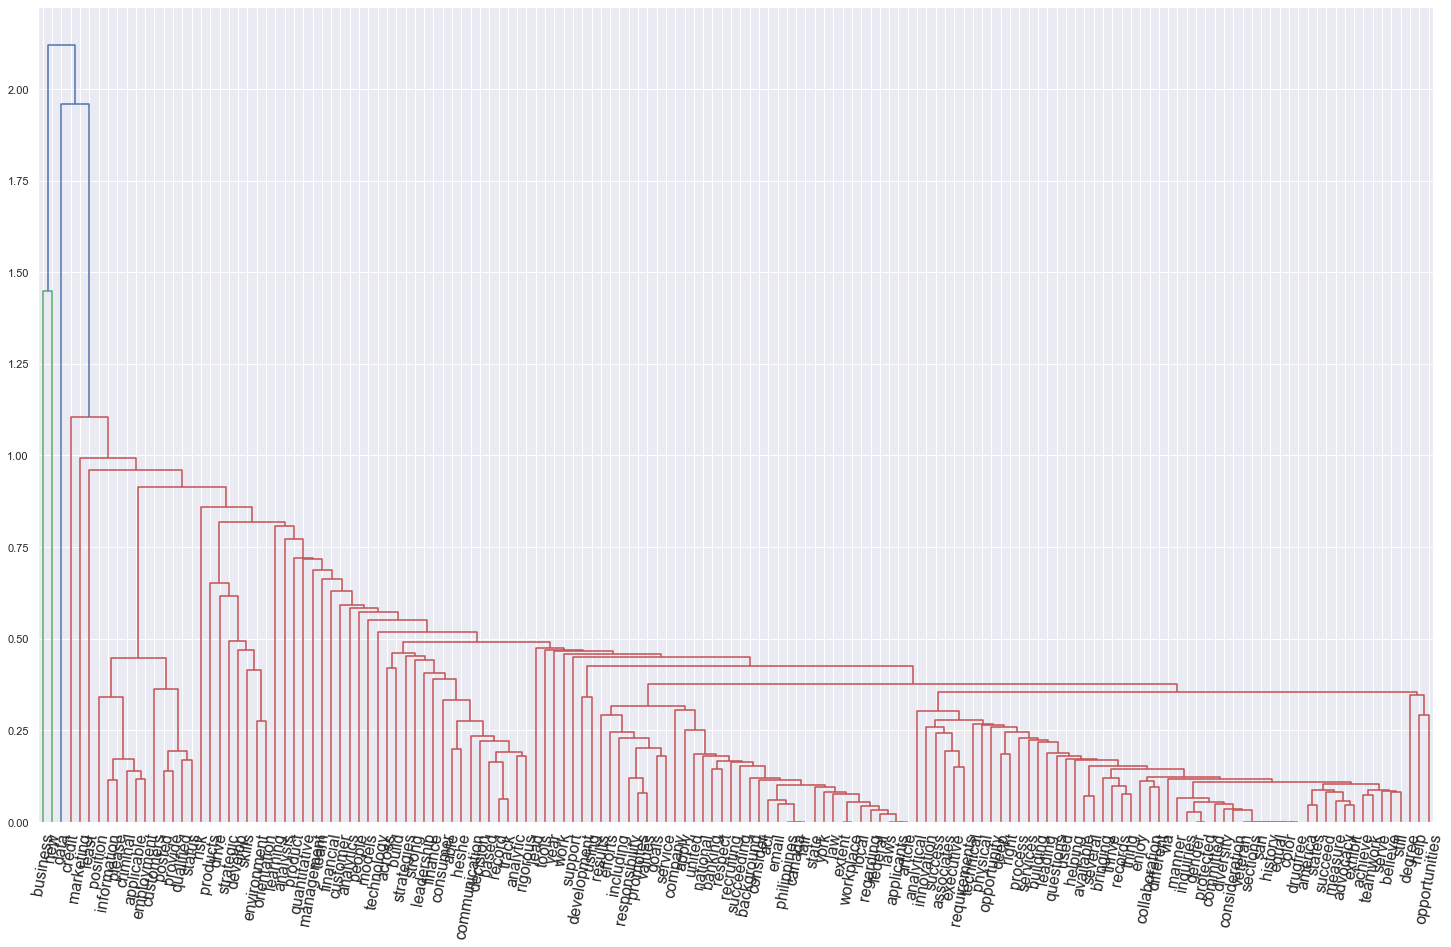

In [498]:
clustdf_t=data_scaled.transpose() # Transpose the df so terms are the rows
c_dist = pdist(clustdf_t) # computing the distance
c_link = linkage(clustdf_t,  metric='euclidean', method='average')# computing the linkage
plt.figure(figsize=(25, 15))  
fig=dendrogram(c_link,labels=list(data_scaled.columns))
plt.xticks(fontsize=16);
plt.xticks(rotation=80);
plt.savefig('Dendrogram_matrix1.png')


In [499]:
#### Matrix 3 - TF-IDF #####
Tfidf=TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
TFIDF_matrix=Tfidf.fit_transform(final_processed_text)     
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns = Tfidf.get_feature_names(), index=job_labels)
# matrix.head()

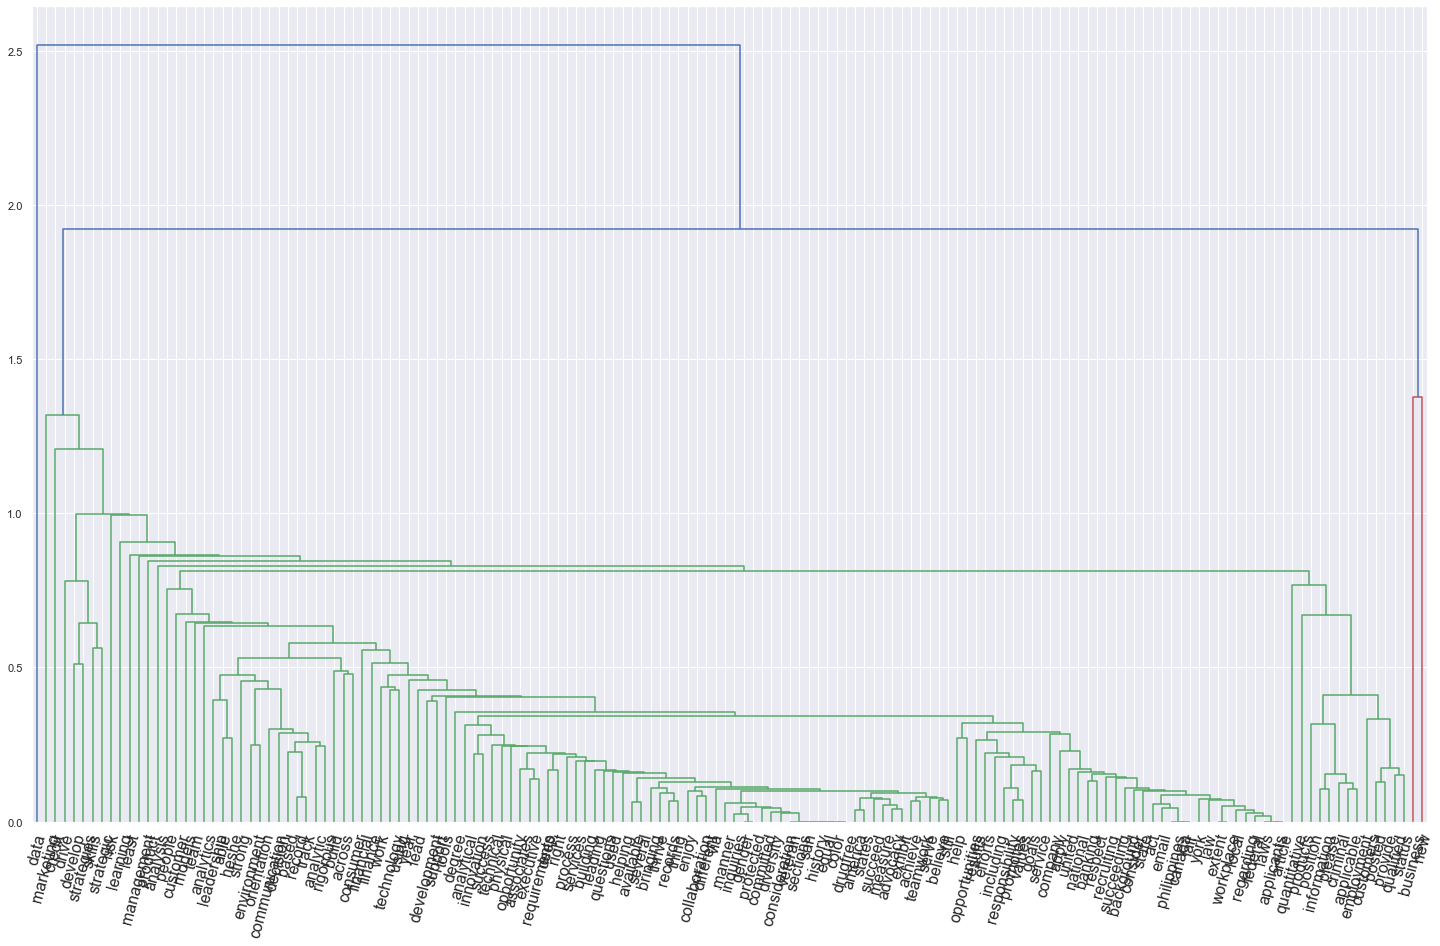

In [500]:
# Cluster and plot
clustdf_t=matrix.transpose() # Transpose the df so terms are the rows
c_dist = pdist(clustdf_t) # computing the distance
c_link = linkage(clustdf_t,  metric='euclidean', method='average')# computing the linkage
# Euclidean is what is used in MDS - will it produce sim results?
plt.figure(figsize=(25, 15))  
B=dendrogram(c_link,labels=list(matrix.columns))
plt.xticks(fontsize=16);
plt.xticks(rotation=75);
plt.savefig('Dendrogram_matrix3.png')

In [509]:
# Use hierarchical clustering to cluster the job 

#### Matrix 3 - TF-IDF #####
VECTOR_LENGTH = 500
Tfidf=TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
TFIDF_matrix=Tfidf.fit_transform(final_processed_text)     
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns = Tfidf.get_feature_names(), index=job_labels)
# matrix.head()

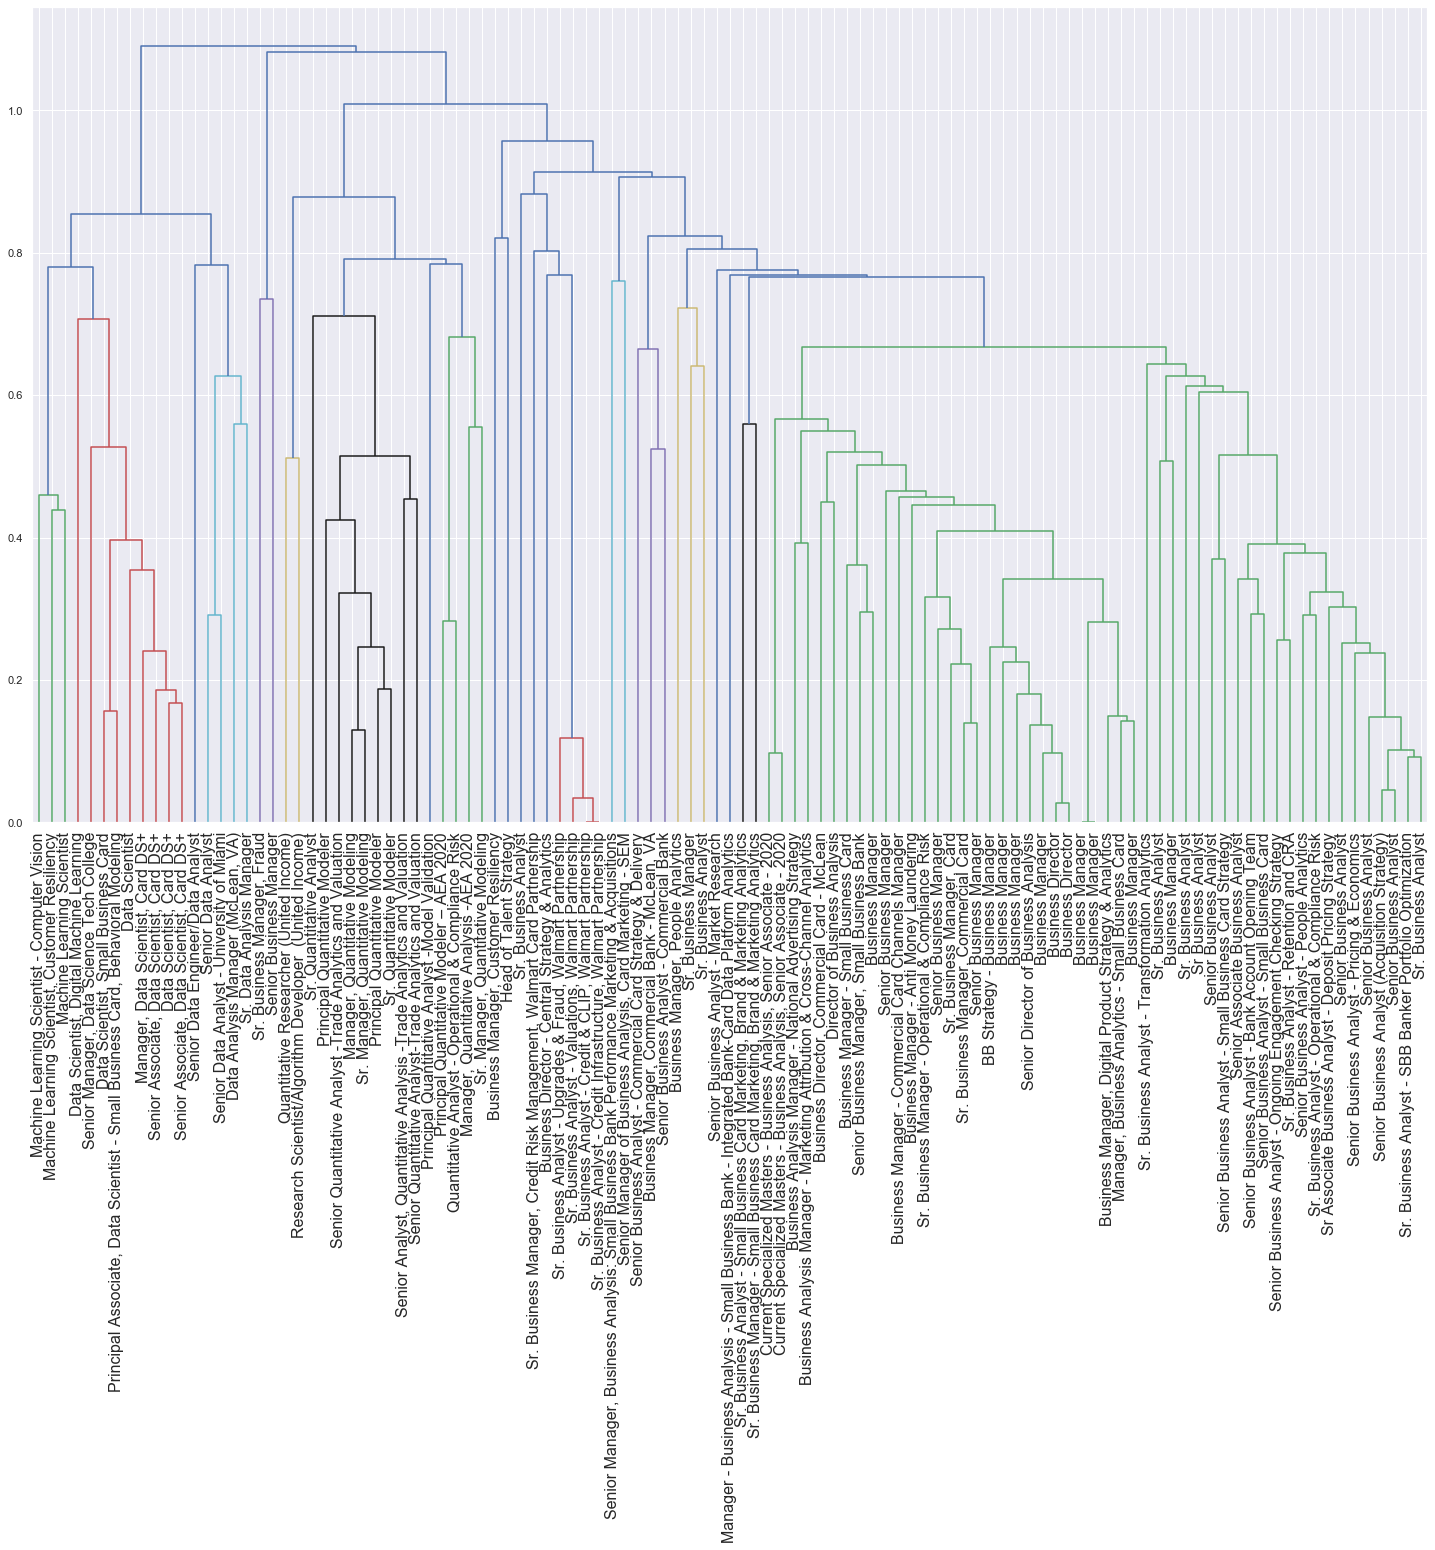

In [512]:
# Cluster and plot
clustdf_t=matrix # use rows - no need to transpose the matirx
c_dist = pdist(clustdf_t) # computing the distance
c_link = linkage(clustdf_t,  metric='euclidean', method='average')# computing the linkage

plt.figure(figsize=(25, 15))  
B=dendrogram(c_link,labels=list(matrix.index.values)) # use rows for labels
plt.xticks(fontsize=16);
#plt.xticks(rotation=75);
plt.savefig('Dendrogram_JOBS_matrix3.png')